## Problem Description

Production prediction is one of the core problems in our business. The provided dataset is a set of nearby wells located in the United States and their 12 months cumulative production. As a data scientist you want to build a model from scratch to predict production and show your manager that your model can perform well on unseen data.

Submitting material: code (Python/notebook) and supporting materials if needed (analysis, documentation, paper, slide)

## Feature Descriptions

- **treatment company**: The treatment company who provides treatment service.
- **azimuth**: Well drilling direction.
- **md (ft)**: Measure depth.
- **tvd (ft)**: True vertical depth.
- **date on production**: First production date.
- **operator**: The well operator who performs drilling service.
- **footage lateral length**: Horizontal well section.
- **well spacing**: Distance to the closest nearby well.
- **porpoise deviation**: How much max (in ft.) a well deviated from its horizontal.
- **porpoise count**: How many times the deviations (porpoises) occurred.
- **shale footage**: How much shale (in ft) encountered in a horizontal well.
- **acoustic impedance**: The impedance of a reservoir rock (ft/s * g/cc).
- **log permeability**: The property of rocks that is an indication of the ability for fluids (gas or liquid) to flow through rocks
- **porosity**: The percentage of void space in a rock. It is defined as the ratio of the volume of the voids or pore space divided by the total volume. It is written as either a decimal fraction between 0 and 1 or as a percentage.
- **poisson ratio**: Measures the ratio of lateral strain to axial strain at linearly elastic region.
- **water saturation**: The ratio of water volume to pore volume.
- **toc**: Total Organic Carbon, indicates the organic richness (hydrocarbon generative potential) of a reservoir rock.
- **vcl**: The amount of clay minerals in a reservoir rock.
- **p-velocity**: The velocity of P-waves (compressional waves) through a reservoir rock (ft/s).
- **s-velocity**: The velocity of S-waves (shear waves) through a reservoir rock (ft/s).
- **youngs modulus**: The ratio of the applied stress to the fractional extension (or shortening) of the reservoir rock parallel to the tension (or compression) (giga pascals).
- **isip**: When the pumps are quickly stopped, and the fluids stop moving, these friction pressures disappear and the resulting pressure is called the instantaneous shut-in pressure, ISIP.
- **breakdown pressure**: The pressure at which a hydraulic fracture is created/initiated/induced.
- **pump rate**: The volume of liquid that travels through the pump in a given time. A hydraulic fracture is formed by pumping fluid into a wellbore at a rate sufficient to increase pressure at the target depth, to exceed that of the fracture gradient (pressure gradient) of the rock.
- **total number of stages**: Total stages used to fracture the horizontal section of the well.
- **proppant volume**: The amount of proppant in pounds used in the completion of a well (lbs).
- **proppant fluid ratio**: The ratio of proppant volume/fluid volume (lbs/gallon).
- **production**: The 12 months cumulative gas production (mmcf).

# 0. Imports

In [1]:
import pickle
import random

import numpy as np
import boruta as bt
import pandas as pd
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import svm

from sklearn import impute as im
from sklearn import metrics as mt
from sklearn import ensemble as en
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

## 0.1. Helper Functions

In [2]:
def settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    #display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

settings()

def cramer_v(x, y):

    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min( kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(models_performance_cv, num_folds, model_name, model, mm_production, x_train, y_train):

    kfold = ms.KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):

        # separate train folds and val fold
        x_train_fold = x_train.iloc[train_cv].copy()
        y_train_fold = y_train.iloc[train_cv].copy()

        x_val_fold = x_train.iloc[val_cv].copy()
        y_val_fold = y_train.iloc[val_cv].copy()

        # train model
        model_fit = model.fit(x_train_fold, y_train_fold)

        # predict values with trained model
        yhat_model = model_fit.predict(x_val_fold)
    
        #performance
        m_result = ml_error(model_name, mm_production.inverse_transform([y_val_fold]), mm_production.inverse_transform([yhat_model]))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

        i+=1

    model_performance = pd.DataFrame({'Model Name': model_name,
                                       'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),}, index=[0])

    models_performance_cv = pd.concat([models_performance_cv, model_performance])
        
    return models_performance_cv

# 1. Data Description

In [3]:
df1 = pd.read_csv('../data/dataset.csv')

In [15]:
df1.head()

,treatment_company,azimuth,md_(ft),tvd_(ft),date_on_production,operator,footage_lateral_length,well_spacing,porpoise_deviation,porpoise_count,shale_footage,acoustic_impedance,log_permeability,porosity,poisson_ratio,water_saturation,toc,vcl,p-velocity,s-velocity,youngs_modulus,isip,breakdown_pressure,pump_rate,total_number_of_stages,proppant_volume,proppant_fluid_ratio,production
0,treatment company 1,-32.2800,19148,6443.0000,2018-03-01,operator 1,11966.0000,4368.4629,6.3300,12,1093,30123.2000,0.6800,0.0200,0.3400,0.8500,5.0000,0.4200,13592.2300,6950.4400,30.8200,4149.0000,NaN,83,56,21568792.0000,1.2300,5614.9480
1,treatment company 2,-19.8000,15150,7602.0000,2014-07-01,operator 2,6890.0000,4714.9922,1.2800,4,0,30951.6100,1.8500,0.1700,0.1900,0.6900,4.2200,0.7400,11735.0400,7162.4500,29.7200,5776.0000,NaN,102,33,9841307.0000,1.4700,2188.8367
2,treatment company 3,-26.8800,14950,5907.0000,2018-08-01,operator 1,8793.0000,798.9210,2.0300,6,3254,28900.2500,0.2900,0.0200,0.3300,NaN,4.6900,0.6100,13227.8100,6976.9300,30.9900,4628.0000,NaN,88,62,17116240.0000,1.6700,1450.0330
3,treatment company 4,-49.1000,11098,6538.0000,2012-01-01,operator 1,4234.0000,NaN,6.0000,23,7470,32826.0800,0.7300,0.0300,0.2000,NaN,4.4000,0.5600,12646.3400,6799.3700,26.2000,4582.0000,NaN,100,11,3749559.0000,0.7700,1060.7644
4,treatment company 5,5.5600,10549,7024.0000,2012-01-01,operator 3,2972.0000,2967.5630,11.8700,9,3637,26740.0500,0.4700,0.0200,0.3300,0.8000,4.6600,0.5800,13192.1800,7046.9100,31.1800,4909.0000,NaN,94,9,6690705.0000,1.3200,607.5304


## 1.1. Rename Columns

In [5]:
df1.columns

Index(['treatment company', 'azimuth', 'md (ft)', 'tvd (ft)',
       'date on production', 'operator', 'footage lateral length',
       'well spacing', 'porpoise deviation', 'porpoise count', 'shale footage',
       'acoustic impedance', 'log permeability', 'porosity', 'poisson ratio',
       'water saturation', 'toc', 'vcl', 'p-velocity', 's-velocity',
       'youngs modulus', 'isip', 'breakdown pressure', 'pump rate',
       'total number of stages', 'proppant volume', 'proppant fluid ratio',
       'production'],
      dtype='object')

In [6]:
# remove spaces in the column names

old_column_names = ['treatment company', 'azimuth', 'md (ft)', 'tvd (ft)', 'date on production', 'operator', 'footage lateral length', 'well spacing', 
                    'porpoise deviation', 'porpoise count', 'shale footage', 'acoustic impedance', 'log permeability', 'porosity', 'poisson ratio', 
                    'water saturation', 'toc', 'vcl', 'p-velocity', 's-velocity', 'youngs modulus', 'isip', 'breakdown pressure', 'pump rate', 
                    'total number of stages', 'proppant volume', 'proppant fluid ratio', 'production']

new_column_names = [old_name.replace(' ', '_') for old_name in old_column_names]

df1.columns = new_column_names

In [7]:
df1.columns

Index(['treatment_company', 'azimuth', 'md_(ft)', 'tvd_(ft)',
       'date_on_production', 'operator', 'footage_lateral_length',
       'well_spacing', 'porpoise_deviation', 'porpoise_count', 'shale_footage',
       'acoustic_impedance', 'log_permeability', 'porosity', 'poisson_ratio',
       'water_saturation', 'toc', 'vcl', 'p-velocity', 's-velocity',
       'youngs_modulus', 'isip', 'breakdown_pressure', 'pump_rate',
       'total_number_of_stages', 'proppant_volume', 'proppant_fluid_ratio',
       'production'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1000
Number of Cols: 28


## 1.3. Data Types

In [9]:
df1.dtypes

treatment_company          object
azimuth                   float64
md_(ft)                     int64
tvd_(ft)                  float64
date_on_production         object
operator                   object
footage_lateral_length    float64
well_spacing              float64
porpoise_deviation        float64
porpoise_count              int64
shale_footage               int64
acoustic_impedance        float64
log_permeability          float64
porosity                  float64
poisson_ratio             float64
water_saturation          float64
toc                       float64
vcl                       float64
p-velocity                float64
s-velocity                float64
youngs_modulus            float64
isip                      float64
breakdown_pressure        float64
pump_rate                   int64
total_number_of_stages      int64
proppant_volume           float64
proppant_fluid_ratio      float64
production                float64
dtype: object

In [14]:
# change 'date_on_production' data type to datetime

df1['date_on_production'] = pd.to_datetime(df1['date_on_production'])
df1.dtypes

treatment_company                 object
azimuth                          float64
md_(ft)                            int64
tvd_(ft)                         float64
date_on_production        datetime64[ns]
operator                          object
footage_lateral_length           float64
well_spacing                     float64
porpoise_deviation               float64
porpoise_count                     int64
shale_footage                      int64
acoustic_impedance               float64
log_permeability                 float64
porosity                         float64
poisson_ratio                    float64
water_saturation                 float64
toc                              float64
vcl                              float64
p-velocity                       float64
s-velocity                       float64
youngs_modulus                   float64
isip                             float64
breakdown_pressure               float64
pump_rate                          int64
total_number_of_

## 1.4. Check NA

In [11]:
df1.isna().sum()

treatment_company           0
azimuth                    55
md_(ft)                     0
tvd_(ft)                   20
date_on_production          0
operator                    0
footage_lateral_length      0
well_spacing              156
porpoise_deviation          0
porpoise_count              0
shale_footage               0
acoustic_impedance          0
log_permeability            0
porosity                  119
poisson_ratio               0
water_saturation          577
toc                        21
vcl                         0
p-velocity                  0
s-velocity                  0
youngs_modulus             19
isip                       77
breakdown_pressure        744
pump_rate                   0
total_number_of_stages      0
proppant_volume           132
proppant_fluid_ratio        0
production                  0
dtype: int64

In [12]:
# replace na values with mean

df1['azimuth'] = df1['azimuth'].replace(np.NaN, df1['azimuth'].mean())
df1['tvd_(ft)'] = df1['tvd_(ft)'].replace(np.NaN, df1['tvd_(ft)'].mean())
df1['well_spacing'] = df1['well_spacing'].replace(np.NaN, df1['well_spacing'].mean())
df1['porosity'] = df1['porosity'].replace(np.NaN, df1['porosity'].mean())
df1['water_saturation'] = df1['water_saturation'].replace(np.NaN, df1['water_saturation'].mean())
df1['toc'] = df1['toc'].replace(np.NaN, df1['toc'].mean())
df1['youngs_modulus'] = df1['youngs_modulus'].replace(np.NaN, df1['youngs_modulus'].mean())
df1['isip'] = df1['isip'].replace(np.NaN, df1['isip'].mean())
df1['breakdown_pressure'] = df1['breakdown_pressure'].replace(np.NaN, df1['breakdown_pressure'].mean())
df1['proppant_volume'] = df1['proppant_volume'].replace(np.NaN, df1['proppant_volume'].mean())

In [13]:
df1.isna().sum()

treatment_company         0
azimuth                   0
md_(ft)                   0
tvd_(ft)                  0
date_on_production        0
operator                  0
footage_lateral_length    0
well_spacing              0
porpoise_deviation        0
porpoise_count            0
shale_footage             0
acoustic_impedance        0
log_permeability          0
porosity                  0
poisson_ratio             0
water_saturation          0
toc                       0
vcl                       0
p-velocity                0
s-velocity                0
youngs_modulus            0
isip                      0
breakdown_pressure        0
pump_rate                 0
total_number_of_stages    0
proppant_volume           0
proppant_fluid_ratio      0
production                0
dtype: int64

## 1.5. Descriptive Statistics

In [14]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1. Numerical Attributes

In [15]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(numerical_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(numerical_attributes.apply(np.std)).T
d2 = pd.DataFrame(numerical_attributes.apply(min)).T
d3 = pd.DataFrame(numerical_attributes.apply(max)).T
d4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,azimuth,-87.2500,22.9400,110.1900,-33.9057,-33.9057,17.4651,0.0103,0.3958
1,md_(ft),8642.0000,27797.0000,19155.0000,13988.3870,13659.5000,2583.0234,0.9320,1.7033
2,tvd_(ft),4859.0000,9639.0000,4780.0000,7103.6204,7026.5000,887.4794,0.2363,-0.7239
3,footage_lateral_length,1329.0000,19849.0000,18520.0000,6387.0495,5927.0000,2519.0698,1.1300,2.0603
4,well_spacing,335.4586,5225.0894,4889.6308,2223.2272,2223.2272,1152.3368,0.6095,-0.3523
5,porpoise_deviation,0.0300,1106.1300,1106.1000,50.4571,10.8800,118.3775,4.1315,20.3260
6,porpoise_count,0.0000,39.0000,39.0000,9.4430,8.0000,6.8792,1.1412,1.2468
7,shale_footage,0.0000,17763.0000,17763.0000,3784.8270,3591.5000,3701.9228,0.8384,0.3560
8,acoustic_impedance,26740.0500,38057.6300,11317.5800,33492.8354,34592.2250,2073.3499,-1.2872,0.5240
9,log_permeability,-0.0300,1.9400,1.9700,0.6236,0.5200,0.3926,0.8898,0.2798


### 1.5.2. Categorical Attributes

In [16]:
categorical_attributes.apply(lambda x: x.unique().shape[0])


treatment_company    31
operator             36
dtype: int64

In [17]:
df1[['treatment_company']].value_counts()

treatment_company   
treatment company 1     130
treatment company 10    120
treatment company 12    116
treatment company 4     113
treatment company 5      85
treatment company 8      77
treatment company 9      76
treatment company 2      71
treatment company 3      70
treatment company 11     30
treatment company 7      29
treatment company 16     23
treatment company 6       9
treatment company 13      9
treatment company 15      7
treatment company 23      5
treatment company 17      4
treatment company 24      3
treatment company 29      3
treatment company 14      3
treatment company 19      3
treatment company 25      2
treatment company 26      2
treatment company 30      2
treatment company 31      2
treatment company 28      1
treatment company 22      1
treatment company 21      1
treatment company 20      1
treatment company 18      1
treatment company 27      1
dtype: int64

In [18]:
df1[['operator']].value_counts()

operator   
operator 4     133
operator 11    130
operator 1     106
operator 5      83
operator 6      73
operator 14     63
operator 8      53
operator 7      46
operator 25     46
operator 20     45
operator 2      40
operator 26     28
operator 9      23
operator 22     18
operator 17     16
operator 19     15
operator 13     13
operator 18     12
operator 15     10
operator 27      7
operator 12      6
operator 16      6
operator 24      4
operator 29      4
operator 3       3
operator 23      3
operator 35      2
operator 33      2
operator 30      2
operator 28      2
operator 34      1
operator 36      1
operator 32      1
operator 21      1
operator 10      1
operator 31      1
dtype: int64

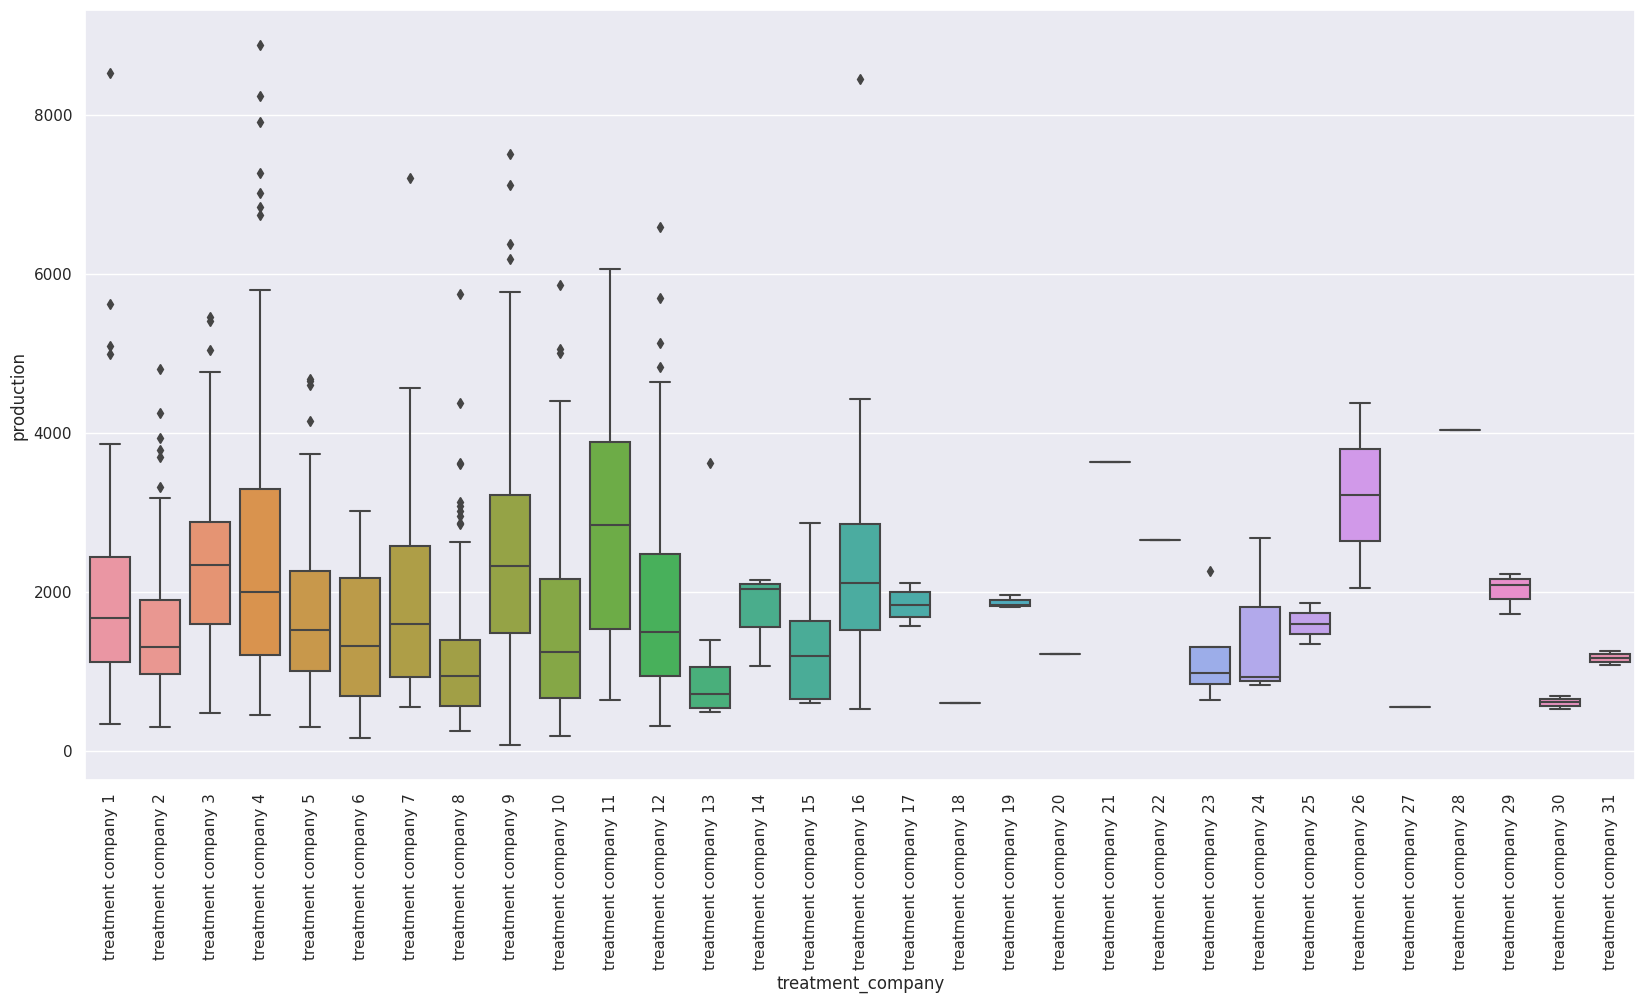

In [19]:
ax = sns.boxplot(x='treatment_company', y='production', data=df1);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

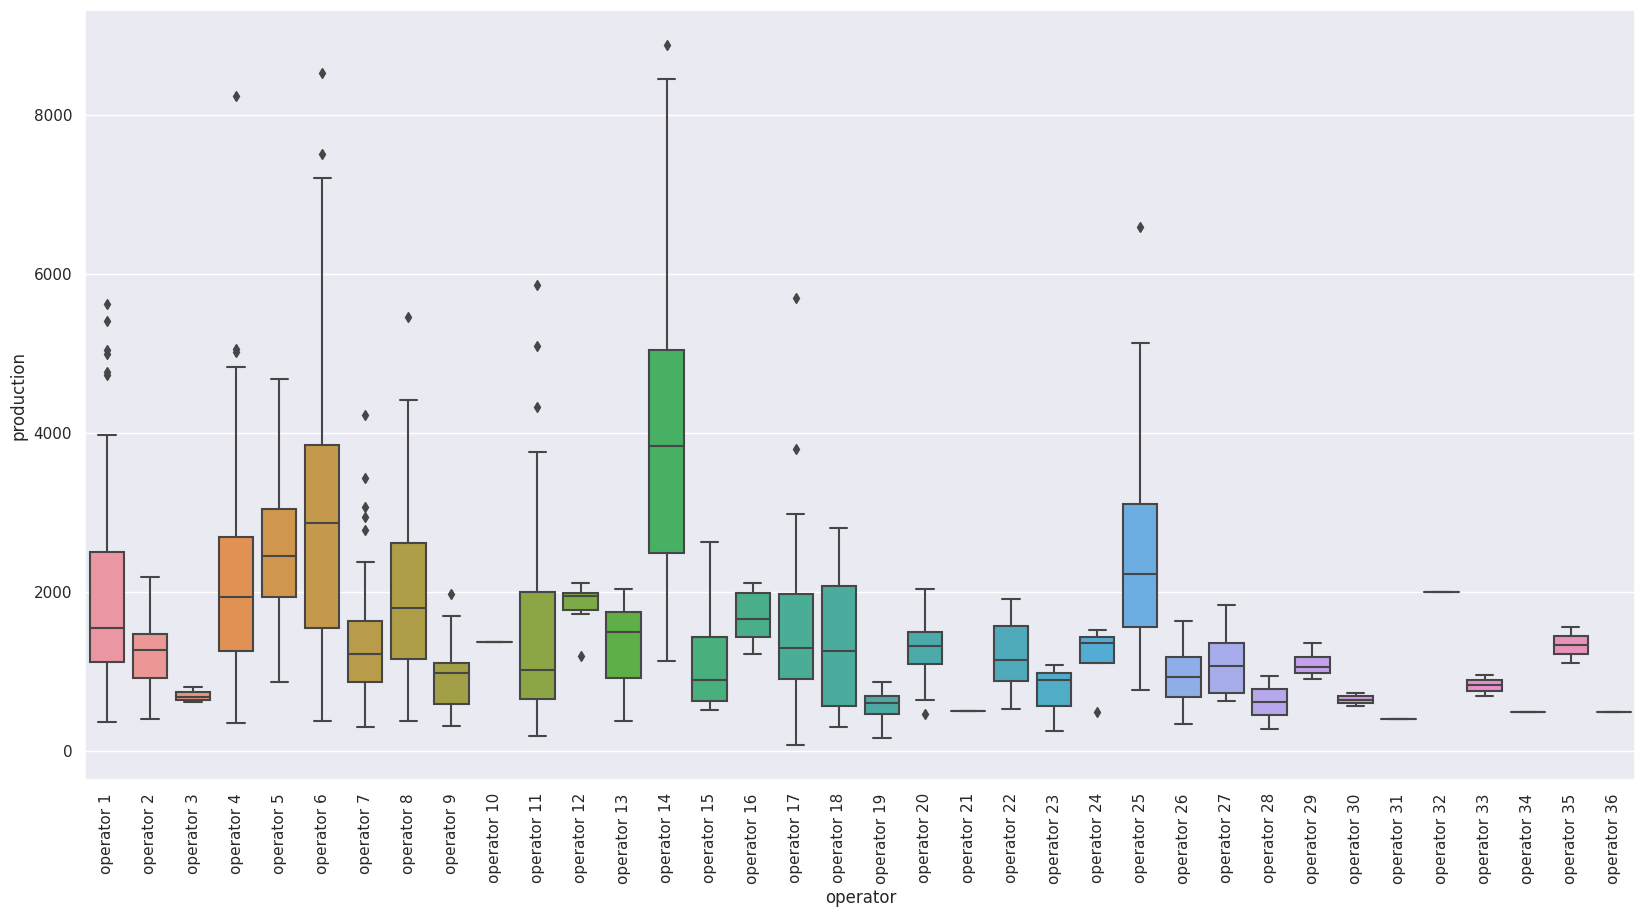

In [20]:
ax = sns.boxplot(x='operator', y='production', data=df1);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

# 2. Feature Engineering

In [21]:
df2 = df1.copy()

In [22]:
df2['month_on_production'] = df2['date_on_production'].dt.month

df2['year_on_production'] = df2['date_on_production'].dt.year

#treatment_company_dict = df2[['treatment_company', 'production']].groupby('treatment_company').mean().T.to_dict('records')[0]
#df2['mean_treatment_company_production'] = df2['treatment_company'].map(treatment_company_dict)
#
#operator_dict = df2[['operator', 'production']].groupby('operator').mean().T.to_dict('records')[0]
#df2['mean_operator_production'] = df2['operator'].map(operator_dict)
#
#total_number_of_stages_dict = df2[['total_number_of_stages', 'production']].groupby('total_number_of_stages').mean().T.to_dict('records')[0]
#df2['mean_total_number_of_stages_production'] = df2['total_number_of_stages'].map(total_number_of_stages_dict)

In [23]:
df2.head()

,treatment_company,azimuth,md_(ft),tvd_(ft),date_on_production,operator,footage_lateral_length,well_spacing,porpoise_deviation,porpoise_count,shale_footage,acoustic_impedance,log_permeability,porosity,poisson_ratio,water_saturation,toc,vcl,p-velocity,s-velocity,youngs_modulus,isip,breakdown_pressure,pump_rate,total_number_of_stages,proppant_volume,proppant_fluid_ratio,production,month_on_production,year_on_production
0,treatment company 1,-32.2800,19148,6443.0000,2018-03-01,operator 1,11966.0000,4368.4629,6.3300,12,1093,30123.2000,0.6800,0.0200,0.3400,0.8500,5.0000,0.4200,13592.2300,6950.4400,30.8200,4149.0000,7365.9492,83,56,21568792.0000,1.2300,5614.9480,3,2018
1,treatment company 2,-19.8000,15150,7602.0000,2014-07-01,operator 2,6890.0000,4714.9922,1.2800,4,0,30951.6100,1.8500,0.1700,0.1900,0.6900,4.2200,0.7400,11735.0400,7162.4500,29.7200,5776.0000,7365.9492,102,33,9841307.0000,1.4700,2188.8367,7,2014
2,treatment company 3,-26.8800,14950,5907.0000,2018-08-01,operator 1,8793.0000,798.9210,2.0300,6,3254,28900.2500,0.2900,0.0200,0.3300,0.7889,4.6900,0.6100,13227.8100,6976.9300,30.9900,4628.0000,7365.9492,88,62,17116240.0000,1.6700,1450.0330,8,2018
3,treatment company 4,-49.1000,11098,6538.0000,2012-01-01,operator 1,4234.0000,2223.2272,6.0000,23,7470,32826.0800,0.7300,0.0300,0.2000,0.7889,4.4000,0.5600,12646.3400,6799.3700,26.2000,4582.0000,7365.9492,100,11,3749559.0000,0.7700,1060.7644,1,2012
4,treatment company 5,5.5600,10549,7024.0000,2012-01-01,operator 3,2972.0000,2967.5630,11.8700,9,3637,26740.0500,0.4700,0.0200,0.3300,0.8000,4.6600,0.5800,13192.1800,7046.9100,31.1800,4909.0000,7365.9492,94,9,6690705.0000,1.3200,607.5304,1,2012


# 3. EDA (Exploratory Data Analysis)

In [24]:
df3 = df2.copy()

In [25]:
numerical_attributes = df3.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df3.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 3.1. Univariate Analysis

### 3.1.1. Response Variable

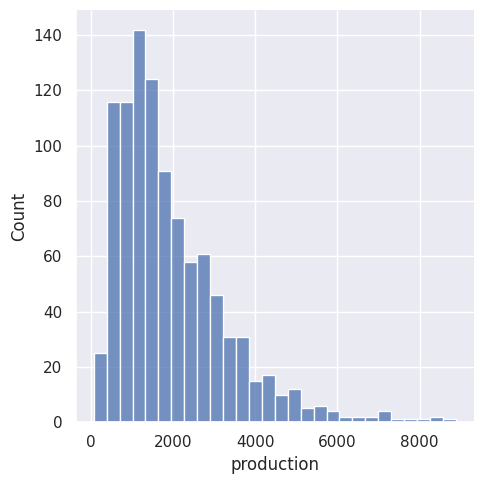

In [26]:
sns.displot(df1['production']);

### 3.1.2. Numerical Variables

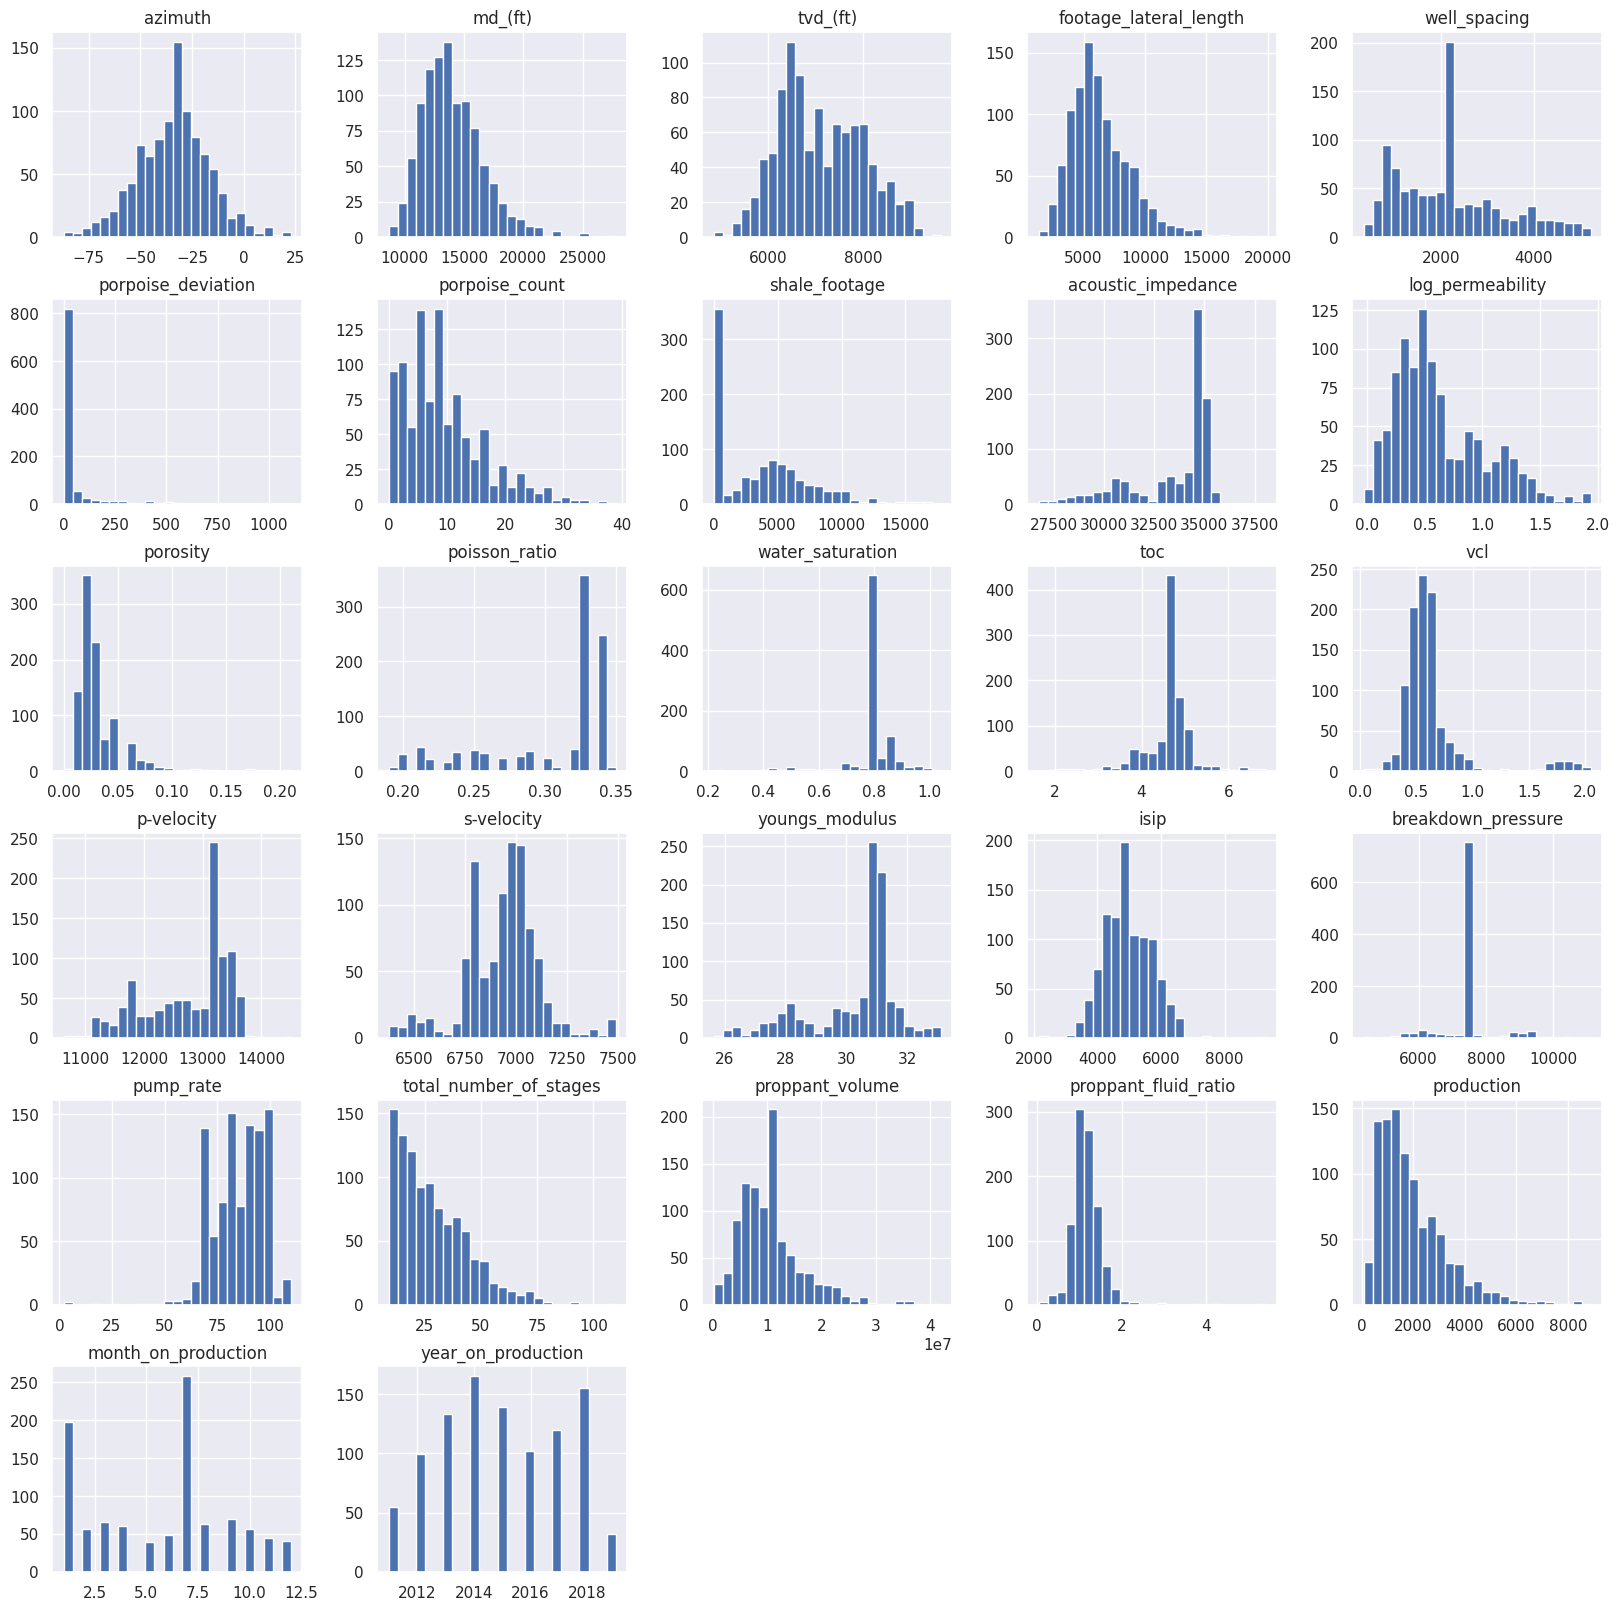

In [27]:
numerical_attributes.hist(bins=25, figsize=[20, 20]);


### 3.1.3. Categorical Variables

<AxesSubplot:>

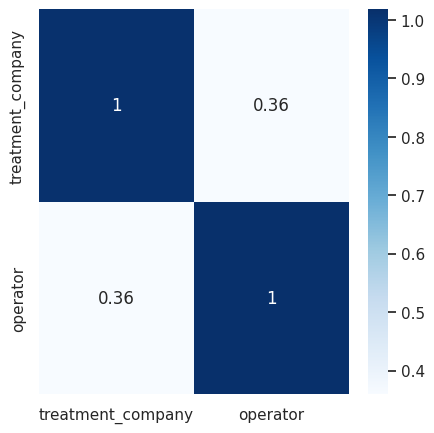

In [28]:
a = df3.select_dtypes(include='object')

a1 = cramer_v(a['treatment_company'], a['treatment_company'])
a2 = cramer_v(a['treatment_company'], a['operator'])

a3 = cramer_v(a['operator'], a['treatment_company'])
a4 = cramer_v(a['operator'], a['operator'])

d = pd.DataFrame({'treatment_company': [a1, a2],
                  'operator': [a3, a4]})

d = d.set_index(d.columns)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(d, cmap="Blues", annot=True)

## 3.2. Bivariate Analysis

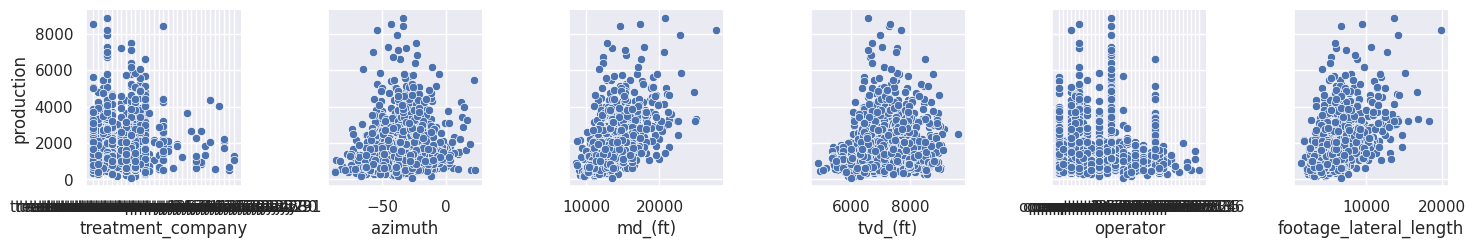

In [29]:
sns.pairplot(df3, y_vars='production', x_vars=['treatment_company', 'azimuth', 'md_(ft)', 'tvd_(ft)', 'operator', 'footage_lateral_length']);

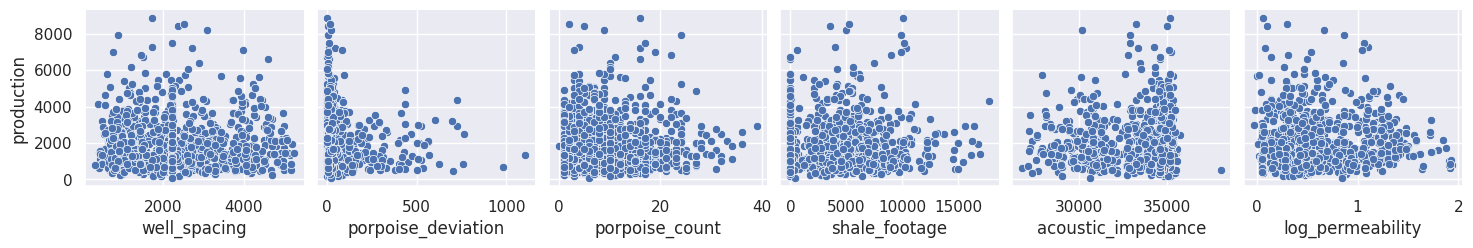

In [30]:
sns.pairplot(df3, y_vars='production', x_vars=['well_spacing', 'porpoise_deviation', 'porpoise_count', 'shale_footage', 'acoustic_impedance', 'log_permeability']);

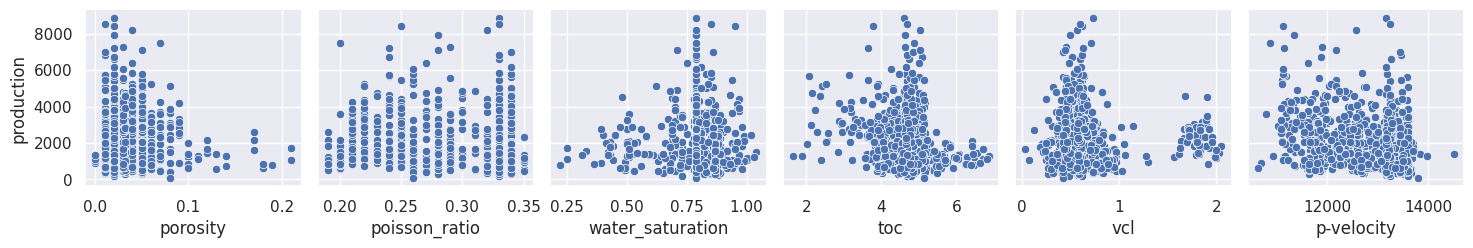

In [31]:
sns.pairplot(df3, y_vars='production', x_vars=['porosity', 'poisson_ratio', 'water_saturation', 'toc', 'vcl', 'p-velocity']);

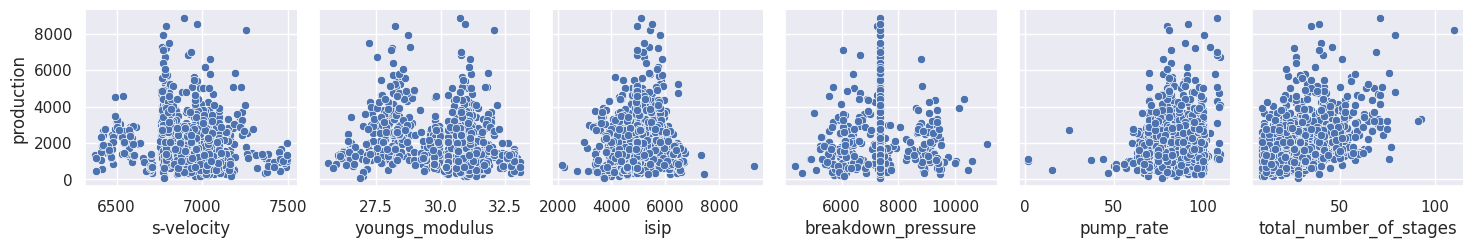

In [32]:
sns.pairplot(df3, y_vars='production', x_vars=['s-velocity', 'youngs_modulus', 'isip', 'breakdown_pressure', 'pump_rate', 'total_number_of_stages']);

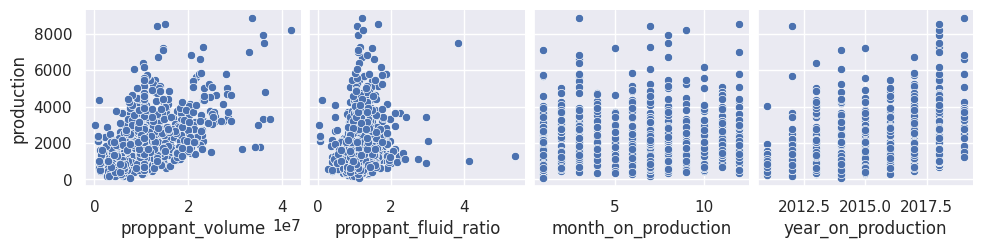

In [33]:
sns.pairplot(df3, y_vars='production', x_vars=['proppant_volume', 'proppant_fluid_ratio', 'month_on_production', 'year_on_production']);

## 3.3. Multivariate Analysis

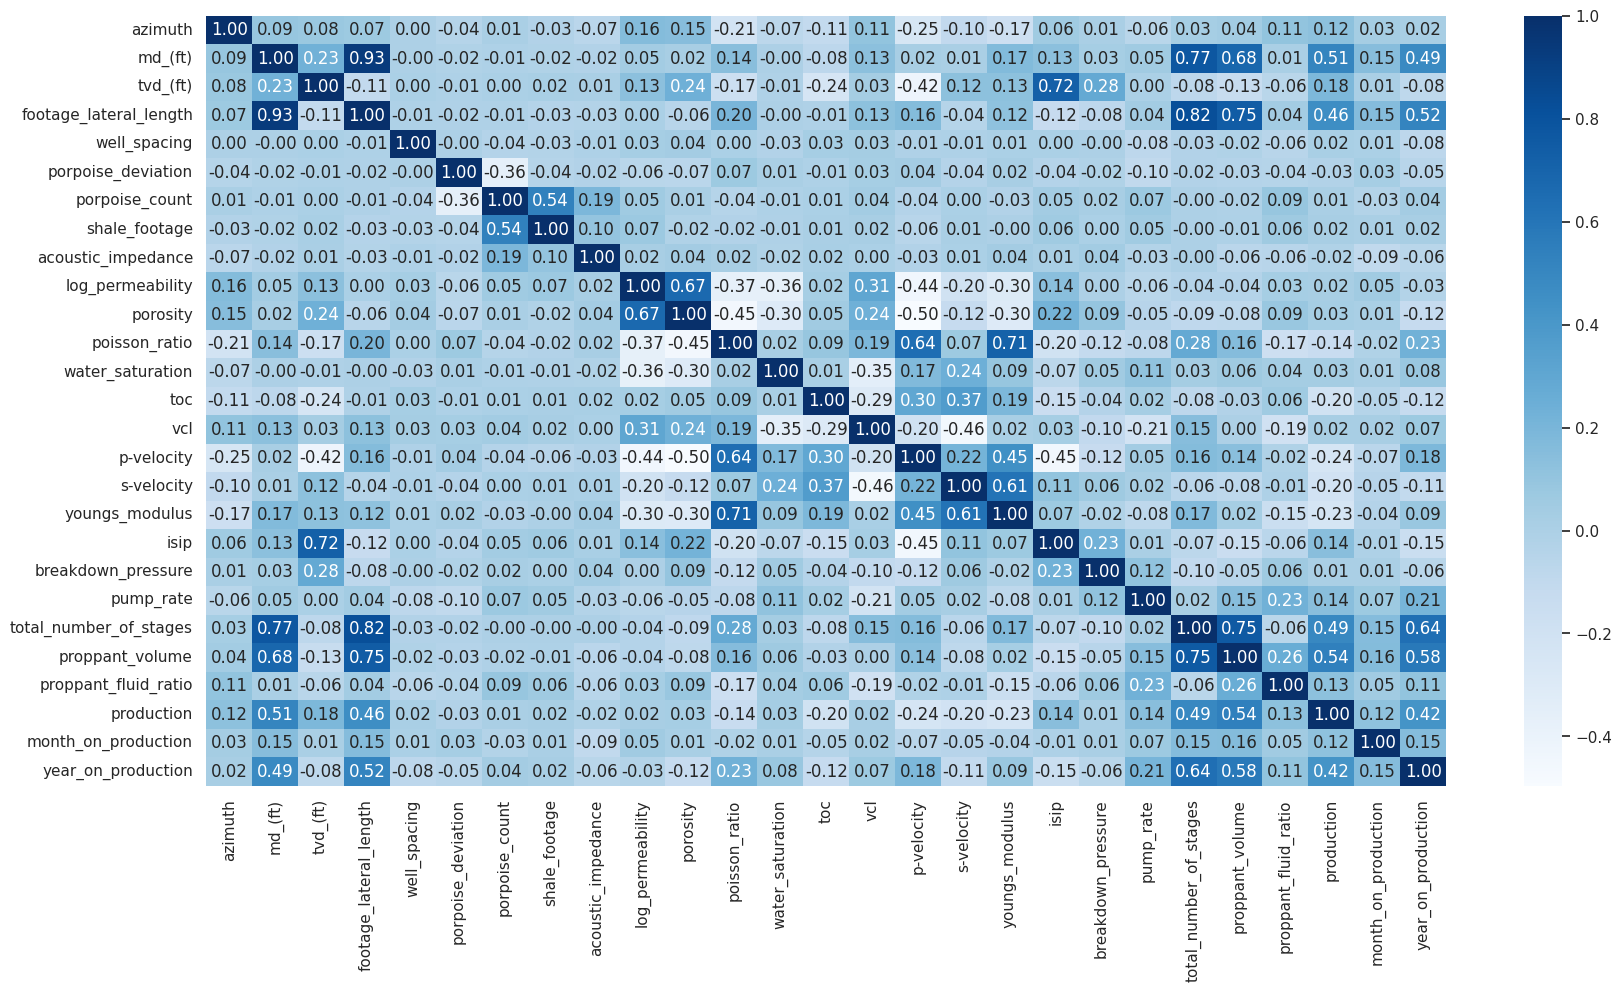

In [34]:
correlation = numerical_attributes.corr(method='pearson');
sns.heatmap(correlation, cmap="Blues", annot=True, fmt='.2f');

# 4. Data Preparation

In [35]:
df4 = df3.copy()

In [36]:
X = df4.drop(['date_on_production', 'production'], axis=1)
y = df4['production'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.20)

df4_train = pd.concat([x_train, y_train], axis=1)
df4_test = pd.concat([x_test, y_test], axis=1)

## 4.1. Feature Encoder

In [37]:
# treatment_company - Target Encoding / Frequency Encoding
fe_treatment_company = df4_train.groupby('treatment_company').size() / len(df4_train)
df4_train['treatment_company'] = df4_train['treatment_company'].map(fe_treatment_company)
#pickle.dump(fe_treatment_company, open('../feature_transformation/fe_treatment_company.pkl', 'wb')) 

# operator - Target Encoding / Frequency Encoding
fe_operator = df4_train.groupby('operator').size() / len(df4_train)
df4_train['operator'] = df4_train['operator'].map(fe_operator)
#pickle.dump(fe_operator, open('../feature_transformation/fe_operator.pkl', 'wb')) 

## 4.2. Feature Scaling

In [38]:
# azimuth - Robust Scaler
rs_azimuth = pp.RobustScaler()
df4_train['azimuth'] = rs_azimuth.fit_transform(df4_train[['azimuth']].values)
#pickle.dump(rs_azimuth, open('../feature_transformation/rs_azimuth.pkl', 'wb'))

# md_(ft) - Mix Max Scaler
mm_md_ft = pp.MinMaxScaler()
df4_train['md_(ft)'] = mm_md_ft.fit_transform(df4_train[['md_(ft)']].values)
#pickle.dump(mm_md_ft, open('../feature_transformation/mm_md_ft.pkl', 'wb'))

# tvd_(ft) - Standard Scaler
ss_tvd_ft = pp.StandardScaler()
df4_train['tvd_(ft)'] = ss_tvd_ft.fit_transform(df4_train[['tvd_(ft)']].values)
#pickle.dump(ss_tvd_ft, open('../feature_transformation/ss_tvd_ft.pkl', 'wb'))

# footage_lateral_length - Min Max Scaler
mm_footage_lateral_length = pp.MinMaxScaler()
df4_train['footage_lateral_length'] = mm_footage_lateral_length.fit_transform(df4_train[['footage_lateral_length']].values)
#pickle.dump(mm_footage_lateral_length, open('../feature_transformation/mm_footage_lateral_length.pkl', 'wb'))

# well_spacing - Min Max Scaler
mm_well_spacing = pp.MinMaxScaler()
df4_train['well_spacing'] = mm_well_spacing.fit_transform(df4_train[['well_spacing']].values)
#pickle.dump(mm_well_spacing, open('../feature_transformation/mm_well_spacing.pkl', 'wb'))

# porpoise_deviation - Min Max Scaler
mm_porpoise_deviation = pp.MinMaxScaler()
df4_train['porpoise_deviation'] = mm_porpoise_deviation.fit_transform(df4_train[['porpoise_deviation']].values)
#pickle.dump(mm_porpoise_deviation, open('../feature_transformation/mm_porpoise_deviation.pkl', 'wb'))

# porpoise_count - Min Max Scaler
mm_porpoise_count = pp.MinMaxScaler()
df4_train['porpoise_count'] = mm_porpoise_count.fit_transform(df4_train[['porpoise_count']].values)
#pickle.dump(mm_porpoise_count, open('../feature_transformation/mm_porpoise_count.pkl', 'wb'))

# shale_footage - Min Max Scaler
mm_shale_footage = pp.MinMaxScaler()
df4_train['shale_footage'] = mm_shale_footage.fit_transform(df4_train[['shale_footage']].values)
#pickle.dump(mm_shale_footage, open('../feature_transformation/mm_shale_footage.pkl', 'wb'))

# acoustic_impedance - Min Max Scaler
mm_acoustic_impedance = pp.MinMaxScaler()
df4_train['acoustic_impedance'] = mm_acoustic_impedance.fit_transform(df4_train[['acoustic_impedance']].values)
#pickle.dump(mm_acoustic_impedance, open('../feature_transformation/mm_acoustic_impedance.pkl', 'wb'))

# log_permeability - Min Max Scaler
mm_log_permeability = pp.MinMaxScaler()
df4_train['log_permeability'] = mm_log_permeability.fit_transform(df4_train[['log_permeability']].values)
#pickle.dump(mm_log_permeability, open('../feature_transformation/mm_log_permeability.pkl', 'wb'))

# porosity - Min Max Scaler
mm_porosity = pp.MinMaxScaler()
df4_train['porosity'] = mm_porosity.fit_transform(df4_train[['porosity']].values)
#pickle.dump(mm_porosity, open('../feature_transformation/mm_porosity.pkl', 'wb'))

# poisson_ratio - Min Max Scaler
mm_poisson_ratio = pp.MinMaxScaler()
df4_train['poisson_ratio'] = mm_poisson_ratio.fit_transform(df4_train[['poisson_ratio']].values)
#pickle.dump(mm_poisson_ratio, open('../feature_transformation/mm_poisson_ratio.pkl', 'wb'))

# water_saturation - Min Max Scaler
mm_water_saturation = pp.MinMaxScaler()
df4_train['water_saturation'] = mm_water_saturation.fit_transform(df4_train[['water_saturation']].values)
#pickle.dump(mm_water_saturation, open('../feature_transformation/mm_water_saturation.pkl', 'wb'))

# toc - Min Max Scaler
mm_toc = pp.MinMaxScaler()
df4_train['toc'] = mm_toc.fit_transform(df4_train[['toc']].values)
#pickle.dump(mm_toc, open('../feature_transformation/mm_toc.pkl', 'wb'))

# vcl - Robust Scaler
rs_vcl = pp.RobustScaler()
df4_train['vcl'] = rs_vcl.fit_transform(df4_train[['vcl']].values)
#pickle.dump(rs_vcl, open('../feature_transformation/rs_vcl.pkl', 'wb'))

# p-velocity - Min Max Scaler
mm_p_velocity = pp.MinMaxScaler()
df4_train['p-velocity'] = mm_p_velocity.fit_transform(df4_train[['p-velocity']].values)
#pickle.dump(mm_p_velocity, open('../feature_transformation/mm_p-velocity.pkl', 'wb'))

# s-velocity - Robust Scaler
rs_s_velocity = pp.RobustScaler()
df4_train['s-velocity'] = rs_s_velocity.fit_transform(df4_train[['s-velocity']].values)
#pickle.dump(rs_s_velocity, open('../feature_transformation/rs_s-velocity.pkl', 'wb'))

# youngs_modulus - Min Max Scaler
mm_youngs_modulus = pp.MinMaxScaler()
df4_train['youngs_modulus'] = mm_youngs_modulus.fit_transform(df4_train[['youngs_modulus']].values)
#pickle.dump(mm_youngs_modulus, open('../feature_transformation/mm_youngs_modulus.pkl', 'wb'))

# isip - Robust Scaler
rs_isip = pp.RobustScaler()
df4_train['isip'] = rs_isip.fit_transform(df4_train[['isip']].values)
#pickle.dump(rs_isip, open('../feature_transformation/rs_isip.pkl', 'wb'))

# breakdown_pressure - Min Max Scaler
mm_breakdown_pressure = pp.MinMaxScaler()
df4_train['breakdown_pressure'] = mm_breakdown_pressure.fit_transform(df4_train[['breakdown_pressure']].values)
#pickle.dump(mm_breakdown_pressure, open('../feature_transformation/mm_breakdown_pressure.pkl', 'wb'))

# pump_rate - Robust Scaler
rs_pump_rate = pp.RobustScaler()
df4_train['pump_rate'] = rs_pump_rate.fit_transform(df4_train[['pump_rate']].values)
#pickle.dump(rs_pump_rate, open('../feature_transformation/rs_pump_rate.pkl', 'wb'))

# total_number_of_stages - Min Max Scaler
mm_total_number_of_stages = pp.MinMaxScaler()
df4_train['total_number_of_stages'] = mm_total_number_of_stages.fit_transform(df4_train[['total_number_of_stages']].values)
#pickle.dump(mm_total_number_of_stages, open('../feature_transformation/mm_total_number_of_stages.pkl', 'wb'))

# proppant_volume - Min Max Scaler
mm_proppant_volume = pp.MinMaxScaler()
df4_train['proppant_volume'] = mm_proppant_volume.fit_transform(df4_train[['proppant_volume']].values)
#pickle.dump(mm_proppant_volume, open('../feature_transformation/mm_proppant_volume.pkl', 'wb'))

# proppant_fluid_ratio - Robust Scaler
rs_proppant_fluid_ratio = pp.RobustScaler()
df4_train['proppant_fluid_ratio'] = rs_proppant_fluid_ratio.fit_transform(df4_train[['proppant_fluid_ratio']].values)
#pickle.dump(rs_proppant_fluid_ratio, open('../feature_transformation/rs_proppant_fluid_ratio.pkl', 'wb'))

# year_on_production - Min Max Scaler
mm_year_on_production = pp.MinMaxScaler()
df4_train['year_on_production'] = mm_year_on_production.fit_transform(df4_train[['year_on_production']].values)
#pickle.dump(mm_year_on_production, open('../feature_transformation/mm_year_on_production.pkl', 'wb'))

## mean_treatment_company_production - Min Max Scaler
#mm_mean_treatment_company_production = pp.MinMaxScaler()
#df4_train['mean_treatment_company_production'] = mm_mean_treatment_company_production.fit_transform(df4_train[['mean_treatment_company_production']].values)
##pickle.dump(mm_mean_treatment_company_production, open('../feature_transformation/mm_mean_treatment_company_production.pkl', 'wb'))
#
## mean_operator_production - Min Max Scaler
#mm_mean_operator_production = pp.MinMaxScaler()
#df4_train['mean_operator_production'] = mm_mean_operator_production.fit_transform(df4_train[['mean_operator_production']].values)
##pickle.dump(mm_mean_operator_production, open('../feature_transformation/mm_mean_operator_production.pkl', 'wb'))
#
## mean_total_number_of_stages_production - Min Max Scaler
#mm_mean_total_number_of_stages_production = pp.MinMaxScaler()
#df4_train['mean_total_number_of_stages_production'] = mm_mean_total_number_of_stages_production.fit_transform(df4_train[['mean_total_number_of_stages_production']].values)
##pickle.dump(mm_mean_total_number_of_stages_production, open('../feature_transformation/mm_mean_total_number_of_stages_production.pkl', 'wb'))

## 4.3. Nature Transformation

In [39]:
df4_train['month_on_production_sin'] = df4_train['month_on_production'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df4_train['month_on_production_cos'] = df4_train['month_on_production'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

## 4.4. Response Scaling

In [40]:
# production - Min Max Scaler
mm_production = pp.MinMaxScaler()
df4_train['production'] = mm_production.fit_transform(df4_train[['production']].values)
#pickle.dump(mm_production, open('../feature_transformation/mm_production.pkl', 'wb'))

## 4.5. Test Data Preparation

In [41]:
# treatment_company - Target Encoding / Frequency Encoding
df4_test['treatment_company'] = df4_test['treatment_company'].map(fe_treatment_company)

# operator - Target Encoding / Frequency Encoding
df4_test['operator'] = df4_test['operator'].map(fe_operator)

In [42]:
# azimuth - Robust Scaler
df4_test['azimuth'] = rs_azimuth.transform(df4_test[['azimuth']].values)

# md_(ft) - Mix Max Scaler
df4_test['md_(ft)'] = mm_md_ft.transform(df4_test[['md_(ft)']].values)

# tvd_(ft) - Standard Scaler
df4_test['tvd_(ft)'] = ss_tvd_ft.transform(df4_test[['tvd_(ft)']].values)

# footage_lateral_length - Min Max Scaler
df4_test['footage_lateral_length'] = mm_footage_lateral_length.transform(df4_test[['footage_lateral_length']].values)

# well_spacing - Min Max Scaler
df4_test['well_spacing'] = mm_well_spacing.transform(df4_test[['well_spacing']].values)

# porpoise_deviation - Min Max Scaler
df4_test['porpoise_deviation'] = mm_porpoise_deviation.transform(df4_test[['porpoise_deviation']].values)

# porpoise_count - Min Max Scaler
df4_test['porpoise_count'] = mm_porpoise_count.transform(df4_test[['porpoise_count']].values)

# shale_footage - Min Max Scaler
df4_test['shale_footage'] = mm_shale_footage.transform(df4_test[['shale_footage']].values)

# acoustic_impedance - Min Max Scaler
df4_test['acoustic_impedance'] = mm_acoustic_impedance.transform(df4_test[['acoustic_impedance']].values)

# log_permeability - Min Max Scaler
df4_test['log_permeability'] = mm_log_permeability.transform(df4_test[['log_permeability']].values)

# porosity - Min Max Scaler
df4_test['porosity'] = mm_porosity.transform(df4_test[['porosity']].values)

# poisson_ratio - Min Max Scaler
df4_test['poisson_ratio'] = mm_poisson_ratio.transform(df4_test[['poisson_ratio']].values)

# water_saturation - Min Max Scaler
df4_test['water_saturation'] = mm_water_saturation.transform(df4_test[['water_saturation']].values)

# toc - Min Max Scaler
df4_test['toc'] = mm_toc.transform(df4_test[['toc']].values)

# vcl - Robust Scaler
df4_test['vcl'] = rs_vcl.transform(df4_test[['vcl']].values)

# p-velocity - Min Max Scaler
df4_test['p-velocity'] = mm_p_velocity.transform(df4_test[['p-velocity']].values)

# s-velocity - Robust Scaler
df4_test['s-velocity'] = rs_s_velocity.transform(df4_test[['s-velocity']].values)

# youngs_modulus - Min Max Scaler
df4_test['youngs_modulus'] = mm_youngs_modulus.transform(df4_test[['youngs_modulus']].values)

# isip - Robust Scaler
df4_test['isip'] = rs_isip.transform(df4_test[['isip']].values)

# breakdown_pressure - Min Max Scaler
df4_test['breakdown_pressure'] = mm_breakdown_pressure.transform(df4_test[['breakdown_pressure']].values)

# pump_rate - Robust Scaler
df4_test['pump_rate'] = rs_pump_rate.transform(df4_test[['pump_rate']].values)

# total_number_of_stages - Min Max Scaler
df4_test['total_number_of_stages'] = mm_total_number_of_stages.transform(df4_test[['total_number_of_stages']].values)

# proppant_volume - Min Max Scaler
df4_test['proppant_volume'] = mm_proppant_volume.transform(df4_test[['proppant_volume']].values)

# proppant_fluid_ratio - Robust Scaler
df4_test['proppant_fluid_ratio'] = rs_proppant_fluid_ratio.transform(df4_test[['proppant_fluid_ratio']].values)

# year_on_production - Min Max Scaler
df4_test['year_on_production'] = mm_year_on_production.transform(df4_test[['year_on_production']].values)

## mean_treatment_company_production - Min Max Scaler
#df4_test['mean_treatment_company_production'] = mm_mean_treatment_company_production.transform(df4_test[['mean_treatment_company_production']].values)
#
## mean_operator_production - Min Max Scaler
#df4_test['mean_operator_production'] = mm_mean_operator_production.transform(df4_test[['mean_operator_production']].values)
#
## mean_total_number_of_stages_production - Min Max Scaler
#df4_test['mean_total_number_of_stages_production'] = mm_mean_total_number_of_stages_production.transform(df4_test[['mean_total_number_of_stages_production']].values)

In [43]:
df4_test['month_on_production_sin'] = df4_test['month_on_production'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df4_test['month_on_production_cos'] = df4_test['month_on_production'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

In [44]:
# production - Min Max Scaler
df4_test['production'] = mm_production.transform(df4_test[['production']].values)

# 5. Feature Selection

In [45]:
df5_train = df4_train.copy()
df5_test = df4_test.copy()

## 5.1. Boruta Feature Selection

In [65]:
x_train_n = df5_train.drop(['month_on_production', 'production'], axis=1).values
y_train_n = df5_train['production'].values.ravel()

# define random forest
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42)

# define boruta
boruta = bt.BorutaPy(rf, n_estimators='auto', verbose=1, max_iter=1000, random_state=42).fit(x_train_n, y_train_n )

Iteration: 1 / 1000
Iteration: 2 / 1000
Iteration: 3 / 1000
Iteration: 4 / 1000
Iteration: 5 / 1000
Iteration: 6 / 1000
Iteration: 7 / 1000
Iteration: 8 / 1000
Iteration: 9 / 1000
Iteration: 10 / 1000
Iteration: 11 / 1000
Iteration: 12 / 1000
Iteration: 13 / 1000
Iteration: 14 / 1000
Iteration: 15 / 1000
Iteration: 16 / 1000
Iteration: 17 / 1000
Iteration: 18 / 1000
Iteration: 19 / 1000
Iteration: 20 / 1000
Iteration: 21 / 1000
Iteration: 22 / 1000
Iteration: 23 / 1000
Iteration: 24 / 1000
Iteration: 25 / 1000
Iteration: 26 / 1000
Iteration: 27 / 1000
Iteration: 28 / 1000
Iteration: 29 / 1000
Iteration: 30 / 1000
Iteration: 31 / 1000
Iteration: 32 / 1000
Iteration: 33 / 1000
Iteration: 34 / 1000
Iteration: 35 / 1000
Iteration: 36 / 1000
Iteration: 37 / 1000
Iteration: 38 / 1000
Iteration: 39 / 1000
Iteration: 40 / 1000
Iteration: 41 / 1000
Iteration: 42 / 1000
Iteration: 43 / 1000
Iteration: 44 / 1000
Iteration: 45 / 1000
Iteration: 46 / 1000
Iteration: 47 / 1000
Iteration: 48 / 1000
I

## 5.1.1. Selected Features

In [47]:
columns_selected = boruta.support_.tolist()

# best features
X_train_fs = df5_train.drop(['month_on_production', 'production'], axis=1)
columns_selected_boruta = X_train_fs.iloc[:, columns_selected].columns.to_list()

columns_selected_boruta

['md_(ft)',
 'tvd_(ft)',
 'operator',
 'p-velocity',
 'youngs_modulus',
 'isip',
 'pump_rate',
 'total_number_of_stages',
 'proppant_volume',
 'proppant_fluid_ratio']

## 5.1.2. Not Selected Features

In [48]:
# not selected features
columns_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, columns_selected_boruta))

columns_not_selected_boruta

['acoustic_impedance',
 'azimuth',
 'breakdown_pressure',
 'footage_lateral_length',
 'log_permeability',
 'month_on_production_cos',
 'month_on_production_sin',
 'poisson_ratio',
 'porosity',
 'porpoise_count',
 'porpoise_deviation',
 's-velocity',
 'shale_footage',
 'toc',
 'treatment_company',
 'vcl',
 'water_saturation',
 'well_spacing',
 'year_on_production']

# 5.2. Tree Feature Importance Selection

In [49]:
# model definition
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42)

# data preparation
x_train_n = df5_train.drop(['month_on_production', 'production'], axis=1)
y_train_n = df5_train['production'].values.ravel()
rf.fit(x_train_n, y_train_n)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [50]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Features Ranking:")
df = pd.DataFrame()
for i, j, k in zip(x_train_n, rf.feature_importances_, range(len(rf.feature_importances_))):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[k])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

columns_selected_tree_importance = ['md_(ft)',
                                    'tvd_(ft)',
                                    'operator',
                                    'p-velocity',
                                    's-velocity',
                                    'youngs_modulus',
                                    'isip',
                                    'pump_rate',
                                    'total_number_of_stages',
                                    'proppant_volume',
                                    'proppant_fluid_ratio',
                                    'footage_lateral_length',
                                    'year_on_production',
                                    'azimuth']

Features Ranking:
                    feature  importance
24          proppant_volume      0.2076
19           youngs_modulus      0.1170
2                   md_(ft)      0.1062
23   total_number_of_stages      0.0698
3                  tvd_(ft)      0.0690
4                  operator      0.0559
20                     isip      0.0499
17               p-velocity      0.0494
25     proppant_fluid_ratio      0.0290
22                pump_rate      0.0248
18               s-velocity      0.0198
5    footage_lateral_length      0.0185
26       year_on_production      0.0167
11         log_permeability      0.0161
1                   azimuth      0.0161
10       acoustic_impedance      0.0141
6              well_spacing      0.0141
7        porpoise_deviation      0.0138
0         treatment_company      0.0128
8            porpoise_count      0.0117
15                      toc      0.0115
28  month_on_production_cos      0.0110
27  month_on_production_sin      0.0094
16                    

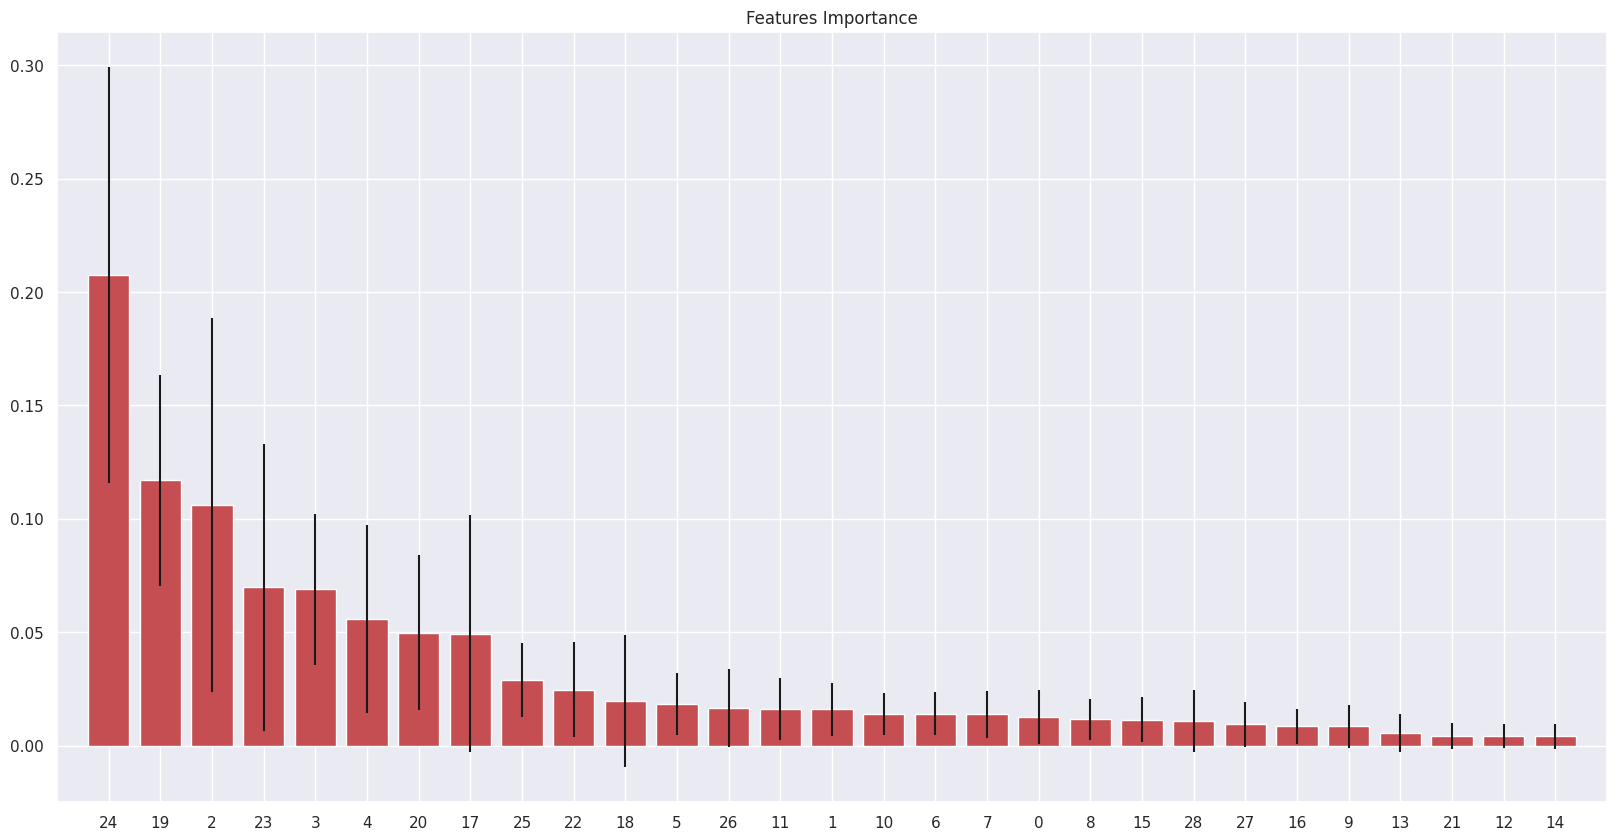

In [51]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Features Importance")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 6. Machine Learning Modeling

In [52]:
df6_train = df5_train.copy()
df6_test = df5_test.copy()

In [53]:
x_train_modeling = df6_train[columns_selected_tree_importance].copy()
y_train_modeling = df6_train['production'].copy()

x_test_modeling = df6_test[columns_selected_tree_importance].copy()
y_test_modeling = df6_test['production'].copy()

In [54]:
# operator - SimpleImputer to avoid NaN values
si_operator = im.SimpleImputer(strategy='most_frequent')
x_test_modeling['operator'] = si_operator.fit_transform(x_test_modeling[['operator']].values)
pickle.dump(si_operator, open('../feature_transformation/si_operator.pkl', 'wb'))

## treatment_company - SimpleImputer to avoid NaN values
#si_treatment_company = im.SimpleImputer(strategy='most_frequent')
#x_test_modeling['treatment_company'] = si_treatment_company.fit_transform(x_test_modeling[['treatment_company']].values)
#pickle.dump(si_treatment_company, open('../feature_transformation/si_treatment_company.pkl', 'wb'))

## 6.1. Linear Regression

In [55]:
# model
lr = lm.LinearRegression().fit(x_train_modeling, y_train_modeling)

# prediction
yhat_lr = lr.predict(x_test_modeling)

# performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test_modeling), np.expm1(yhat_lr))
lr_result = ml_error('Linear Regression', mm_production.inverse_transform([y_test_modeling]), mm_production.inverse_transform([yhat_lr]))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,657.9081,0.4655,905.5585


## 6.2. Lasso (Least Absolute Shrinkage and Selection Operator)

In [56]:
# model
la = lm.Lasso().fit(x_train_modeling, y_train_modeling)

# prediction
yhat_la = la.predict(x_test_modeling)

# performance
la_result = ml_error('Lasso', mm_production.inverse_transform([y_test_modeling]), mm_production.inverse_transform([yhat_la]))
la_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1052.5239,0.9485,1343.7341


## 6.3. SVM (Support Vector Machine)

In [57]:
# model
svmr = svm.SVR().fit(x_train_modeling, y_train_modeling)

# prediction
yhat_svmr = svmr.predict(x_test_modeling)

# performance
svmr_result = ml_error('SVM', mm_production.inverse_transform([y_test_modeling]), mm_production.inverse_transform([yhat_svmr]))
svmr_result

,Model Name,MAE,MAPE,RMSE
0,SVM,617.8692,0.5078,823.9631


## 6.4. Random Forest

In [58]:
# model
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42).fit(x_train_modeling, y_train_modeling)

# prediction
yhat_rf = rf.predict(x_test_modeling)

# performance
rf_result = ml_error('Random Forest', mm_production.inverse_transform([y_test_modeling]), mm_production.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,497.6762,0.3185,728.0513


## 6.5. XGBoost (Extreme Gradient Boosting)

In [59]:
# model tree_method ='gpu_hist'
xgbm = xgb.XGBRegressor(random_state=42).fit(x_train_modeling, y_train_modeling)

# prediction
yhat_xgbm = xgbm.predict(x_test_modeling)

# performance
xgbm_result = ml_error('XGBoost', mm_production.inverse_transform([y_test_modeling]), mm_production.inverse_transform([yhat_xgbm]))
xgbm_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,485.3690,0.3057,715.2700


## 6.6. LightGBM (Light Gradient Boosting Machine)

In [60]:
# model
lgbm = lgb.LGBMRegressor(random_state=42).fit(x_train_modeling, y_train_modeling)

# prediction
yhat_lgbm = lgbm.predict(x_test_modeling)

# performance
lgbm_result = ml_error('LightGBM', mm_production.inverse_transform([y_test_modeling]), mm_production.inverse_transform([yhat_lgbm]))
lgbm_result

,Model Name,MAE,MAPE,RMSE
0,LightGBM,492.1176,0.3205,747.4458


## 6.7. CatBoost (Categorical Boosting)

In [61]:
# model
ctbm = ctb.CatBoostRegressor(verbose=0, random_seed=42, allow_writing_files=False).fit(x_train_modeling, y_train_modeling)

# prediction
yhat_ctbm = ctbm.predict(x_test_modeling)

# performance
ctbm_result = ml_error('CatBoost', mm_production.inverse_transform([y_test_modeling]), mm_production.inverse_transform([yhat_ctbm]))
ctbm_result

,Model Name,MAE,MAPE,RMSE
0,CatBoost,447.2175,0.2739,675.3244


## 6.8. Models Performance

### 6.8.1. Single Performance

In [62]:
modelling_result = pd.concat([lr_result, la_result, svmr_result, rf_result, xgbm_result, lgbm_result, ctbm_result])
modelling_result.sort_values('RMSE').reset_index(drop=True)

,Model Name,MAE,MAPE,RMSE
0,CatBoost,447.2175,0.2739,675.3244
1,XGBoost,485.3690,0.3057,715.2700
2,Random Forest,497.6762,0.3185,728.0513
3,LightGBM,492.1176,0.3205,747.4458
4,SVM,617.8692,0.5078,823.9631
5,Linear Regression,657.9081,0.4655,905.5585
6,Lasso,1052.5239,0.9485,1343.7341


### 6.8.2. Cross Validation Performance

In [63]:
df4_cv = df4.copy().sample(frac=1, random_state=42)

In [64]:
# treatment_company - Target Encoding / Frequency Encoding
fe_treatment_company = df4_cv.groupby('treatment_company').size() / len(df4_cv)
df4_cv['treatment_company'] = df4_cv['treatment_company'].map(fe_treatment_company)
#pickle.dump(fe_treatment_company, open('../feature_transformation/fe_treatment_company.pkl', 'wb')) 

# operator - Target Encoding / Frequency Encoding
fe_operator = df4_cv.groupby('operator').size() / len(df4_cv)
df4_cv['operator'] = df4_cv['operator'].map(fe_operator)
pickle.dump(fe_operator, open('../feature_transformation/fe_operator.pkl', 'wb')) 

# azimuth - Robust Scaler
rs_azimuth = pp.RobustScaler()
df4_cv['azimuth'] = rs_azimuth.fit_transform(df4_cv[['azimuth']].values)
pickle.dump(rs_azimuth, open('../feature_transformation/rs_azimuth.pkl', 'wb'))

# md_(ft) - Mix Max Scaler
mm_md_ft = pp.MinMaxScaler()
df4_cv['md_(ft)'] = mm_md_ft.fit_transform(df4_cv[['md_(ft)']].values)
pickle.dump(mm_md_ft, open('../feature_transformation/mm_md_ft.pkl', 'wb'))

# tvd_(ft) - Standard Scaler
ss_tvd_ft = pp.StandardScaler()
df4_cv['tvd_(ft)'] = ss_tvd_ft.fit_transform(df4_cv[['tvd_(ft)']].values)
pickle.dump(ss_tvd_ft, open('../feature_transformation/ss_tvd_ft.pkl', 'wb'))

# footage_lateral_length - Min Max Scaler
mm_footage_lateral_length = pp.MinMaxScaler()
df4_cv['footage_lateral_length'] = mm_footage_lateral_length.fit_transform(df4_cv[['footage_lateral_length']].values)
pickle.dump(mm_footage_lateral_length, open('../feature_transformation/mm_footage_lateral_length.pkl', 'wb'))

# well_spacing - Min Max Scaler
mm_well_spacing = pp.MinMaxScaler()
df4_cv['well_spacing'] = mm_well_spacing.fit_transform(df4_cv[['well_spacing']].values)
#pickle.dump(mm_well_spacing, open('../feature_transformation/mm_well_spacing.pkl', 'wb'))

# porpoise_deviation - Min Max Scaler
mm_porpoise_deviation = pp.MinMaxScaler()
df4_cv['porpoise_deviation'] = mm_porpoise_deviation.fit_transform(df4_cv[['porpoise_deviation']].values)
#pickle.dump(mm_porpoise_deviation, open('../feature_transformation/mm_porpoise_deviation.pkl', 'wb'))

# porpoise_count - Min Max Scaler
mm_porpoise_count = pp.MinMaxScaler()
df4_cv['porpoise_count'] = mm_porpoise_count.fit_transform(df4_cv[['porpoise_count']].values)
#pickle.dump(mm_porpoise_count, open('../feature_transformation/mm_porpoise_count.pkl', 'wb'))

# shale_footage - Min Max Scaler
mm_shale_footage = pp.MinMaxScaler()
df4_cv['shale_footage'] = mm_shale_footage.fit_transform(df4_cv[['shale_footage']].values)
#pickle.dump(mm_shale_footage, open('../feature_transformation/mm_shale_footage.pkl', 'wb'))

# acoustic_impedance - Min Max Scaler
mm_acoustic_impedance = pp.MinMaxScaler()
df4_cv['acoustic_impedance'] = mm_acoustic_impedance.fit_transform(df4_cv[['acoustic_impedance']].values)
#pickle.dump(mm_acoustic_impedance, open('../feature_transformation/mm_acoustic_impedance.pkl', 'wb'))

# log_permeability - Min Max Scaler
mm_log_permeability = pp.MinMaxScaler()
df4_cv['log_permeability'] = mm_log_permeability.fit_transform(df4_cv[['log_permeability']].values)
#pickle.dump(mm_log_permeability, open('../feature_transformation/mm_log_permeability.pkl', 'wb'))

# porosity - Min Max Scaler
mm_porosity = pp.MinMaxScaler()
df4_cv['porosity'] = mm_porosity.fit_transform(df4_cv[['porosity']].values)
#pickle.dump(mm_porosity, open('../feature_transformation/mm_porosity.pkl', 'wb'))

# poisson_ratio - Min Max Scaler
mm_poisson_ratio = pp.MinMaxScaler()
df4_cv['poisson_ratio'] = mm_poisson_ratio.fit_transform(df4_cv[['poisson_ratio']].values)
#pickle.dump(mm_poisson_ratio, open('../feature_transformation/mm_poisson_ratio.pkl', 'wb'))

# water_saturation - Min Max Scaler
mm_water_saturation = pp.MinMaxScaler()
df4_cv['water_saturation'] = mm_water_saturation.fit_transform(df4_cv[['water_saturation']].values)
#pickle.dump(mm_water_saturation, open('../feature_transformation/mm_water_saturation.pkl', 'wb'))

# toc - Min Max Scaler
mm_toc = pp.MinMaxScaler()
df4_cv['toc'] = mm_toc.fit_transform(df4_cv[['toc']].values)
#pickle.dump(mm_toc, open('../feature_transformation/mm_toc.pkl', 'wb'))

# vcl - Robust Scaler
rs_vcl = pp.RobustScaler()
df4_cv['vcl'] = rs_vcl.fit_transform(df4_cv[['vcl']].values)
#pickle.dump(rs_vcl, open('../feature_transformation/rs_vcl.pkl', 'wb'))

# p-velocity - Min Max Scaler
mm_p_velocity = pp.MinMaxScaler()
df4_cv['p-velocity'] = mm_p_velocity.fit_transform(df4_cv[['p-velocity']].values)
pickle.dump(mm_p_velocity, open('../feature_transformation/mm_p-velocity.pkl', 'wb'))

# s-velocity - Robust Scaler
rs_s_velocity = pp.RobustScaler()
df4_cv['s-velocity'] = rs_s_velocity.fit_transform(df4_cv[['s-velocity']].values)
pickle.dump(rs_s_velocity, open('../feature_transformation/rs_s-velocity.pkl', 'wb'))

# youngs_modulus - Min Max Scaler
mm_youngs_modulus = pp.MinMaxScaler()
df4_cv['youngs_modulus'] = mm_youngs_modulus.fit_transform(df4_cv[['youngs_modulus']].values)
pickle.dump(mm_youngs_modulus, open('../feature_transformation/mm_youngs_modulus.pkl', 'wb'))

# isip - Robust Scaler
rs_isip = pp.RobustScaler()
df4_cv['isip'] = rs_isip.fit_transform(df4_cv[['isip']].values)
pickle.dump(rs_isip, open('../feature_transformation/rs_isip.pkl', 'wb'))

# breakdown_pressure - Min Max Scaler
mm_breakdown_pressure = pp.MinMaxScaler()
df4_cv['breakdown_pressure'] = mm_breakdown_pressure.fit_transform(df4_cv[['breakdown_pressure']].values)
#pickle.dump(mm_breakdown_pressure, open('../feature_transformation/mm_breakdown_pressure.pkl', 'wb'))

# pump_rate - Robust Scaler
rs_pump_rate = pp.RobustScaler()
df4_cv['pump_rate'] = rs_pump_rate.fit_transform(df4_cv[['pump_rate']].values)
pickle.dump(rs_pump_rate, open('../feature_transformation/rs_pump_rate.pkl', 'wb'))

# total_number_of_stages - Min Max Scaler
mm_total_number_of_stages = pp.MinMaxScaler()
df4_cv['total_number_of_stages'] = mm_total_number_of_stages.fit_transform(df4_cv[['total_number_of_stages']].values)
pickle.dump(mm_total_number_of_stages, open('../feature_transformation/mm_total_number_of_stages.pkl', 'wb'))

# proppant_volume - Min Max Scaler
mm_proppant_volume = pp.MinMaxScaler()
df4_cv['proppant_volume'] = mm_proppant_volume.fit_transform(df4_cv[['proppant_volume']].values)
pickle.dump(mm_proppant_volume, open('../feature_transformation/mm_proppant_volume.pkl', 'wb'))

# proppant_fluid_ratio - Robust Scaler
rs_proppant_fluid_ratio = pp.RobustScaler()
df4_cv['proppant_fluid_ratio'] = rs_proppant_fluid_ratio.fit_transform(df4_cv[['proppant_fluid_ratio']].values)
pickle.dump(rs_proppant_fluid_ratio, open('../feature_transformation/rs_proppant_fluid_ratio.pkl', 'wb'))

# year_on_production - Min Max Scaler
mm_year_on_production = pp.MinMaxScaler()
df4_cv['year_on_production'] = mm_year_on_production.fit_transform(df4_cv[['year_on_production']].values)
pickle.dump(mm_year_on_production, open('../feature_transformation/mm_year_on_production.pkl', 'wb'))

## mean_treatment_company_production - Min Max Scaler
#mm_mean_treatment_company_production = pp.MinMaxScaler()
#df4_cv['mean_treatment_company_production'] = mm_mean_treatment_company_production.fit_transform(df4_cv[['mean_treatment_company_production']].values)
#pickle.dump(mm_mean_treatment_company_production, open('../feature_transformation/mm_mean_treatment_company_production.pkl', 'wb'))
#
## mean_operator_production - Min Max Scaler
#mm_mean_operator_production = pp.MinMaxScaler()
#df4_cv['mean_operator_production'] = mm_mean_operator_production.fit_transform(df4_cv[['mean_operator_production']].values)
#pickle.dump(mm_mean_operator_production, open('../feature_transformation/mm_mean_operator_production.pkl', 'wb'))
#
## mean_total_number_of_stages_production - Min Max Scaler
#mm_mean_total_number_of_stages_production = pp.MinMaxScaler()
#df4_cv['mean_total_number_of_stages_production'] = mm_mean_total_number_of_stages_production.fit_transform(df4_cv[['mean_total_number_of_stages_production']].values)
#pickle.dump(mm_mean_total_number_of_stages_production, open('../feature_transformation/mm_mean_total_number_of_stages_production.pkl', 'wb'))

df4_cv['month_on_production_sin'] = df4_cv['month_on_production'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df4_cv['month_on_production_cos'] = df4_cv['month_on_production'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# production - Min Max Scaler
mm_production = pp.MinMaxScaler()
df4_cv['production'] = mm_production.fit_transform(df4_cv[['production']].values)
pickle.dump(mm_production, open('../feature_transformation/mm_production.pkl', 'wb'))

In [138]:
x_train_modeling_cv = df4_cv[columns_selected_tree_importance].copy()
y_train_modeling_cv = df4_cv['production'].copy()

In [139]:
models_performance_cv = pd.DataFrame({'Model Name':[], "MAE CV":[], "MAPE CV":[], "RMSE CV":[]})

models_performance_cv = cross_validation(models_performance_cv, 5, 'Linear Regression', lr, mm_production, x_train_modeling_cv, y_train_modeling_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Lasso', la, mm_production, x_train_modeling_cv, y_train_modeling_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'SVM', svmr, mm_production, x_train_modeling_cv, y_train_modeling_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Random Forest', rf, mm_production, x_train_modeling_cv, y_train_modeling_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'XGBoost', xgbm, mm_production, x_train_modeling_cv, y_train_modeling_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'LightGBM', lgbm, mm_production, x_train_modeling_cv, y_train_modeling_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'CatBoost', ctbm, mm_production, x_train_modeling_cv, y_train_modeling_cv)

models_performance_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,687.8 +/- 49.4,0.49 +/- 0.04,974.12 +/- 90.88
0,Lasso,1023.65 +/- 61.45,0.89 +/- 0.06,1348.19 +/- 96.97
0,SVM,651.62 +/- 28.27,0.51 +/- 0.06,897.34 +/- 60.87
0,Random Forest,521.82 +/- 26.99,0.36 +/- 0.02,768.7 +/- 74.63
0,XGBoost,526.78 +/- 14.36,0.35 +/- 0.02,773.11 +/- 52.73
0,LightGBM,525.71 +/- 31.97,0.34 +/- 0.02,767.4 +/- 58.25
0,CatBoost,490.18 +/- 16.5,0.32 +/- 0.02,724.79 +/- 54.17


# 7. Hyperparameter Fine Tuning

## 7.1. Random Search

### 7.1.1. CatBoost

In [140]:
param_ctbm = {'learning_rate': [0.035, 0.04, 0.045],
              'depth': [4, 6, 8],
              'l2_leaf_reg': [2, 3, 4],
              'random_strength': [0.5, 0.75, 1],
              'iterations': [750, 1000, 1250]}

max_eval_ctbm = 10

In [141]:
final_result_ctbm = pd.DataFrame()

for i in range(max_eval_ctbm):
    # choose values for parameters randomly
    hp = {k:random.sample(v, 1)[0] for k, v in param_ctbm.items()}
    print("Iteration {}: {}".format(i + 1, hp))

    # model
    ctbm = ctb.CatBoostRegressor(verbose=0,
                                 random_state=42,
                                 allow_writing_files=False,
                                 learning_rate=hp['learning_rate'],
                                 depth=hp['depth'],
                                 l2_leaf_reg=hp['l2_leaf_reg'],
                                 random_strength=hp['random_strength'],
                                 iterations=hp['iterations'])

    # model performance
    final_result_ctbm = cross_validation(final_result_ctbm, 5, 'CatBoost' + ' {}'.format(i + 1), ctbm, mm_production, x_train_modeling_cv, y_train_modeling_cv)

final_result_ctbm

Iteration 1: {'learning_rate': 0.045, 'depth': 4, 'l2_leaf_reg': 4, 'random_strength': 1, 'iterations': 1250}
Iteration 2: {'learning_rate': 0.04, 'depth': 4, 'l2_leaf_reg': 4, 'random_strength': 0.75, 'iterations': 750}
Iteration 3: {'learning_rate': 0.035, 'depth': 6, 'l2_leaf_reg': 4, 'random_strength': 0.5, 'iterations': 1000}
Iteration 4: {'learning_rate': 0.045, 'depth': 8, 'l2_leaf_reg': 3, 'random_strength': 0.75, 'iterations': 1250}
Iteration 5: {'learning_rate': 0.035, 'depth': 4, 'l2_leaf_reg': 2, 'random_strength': 0.75, 'iterations': 750}
Iteration 6: {'learning_rate': 0.04, 'depth': 8, 'l2_leaf_reg': 3, 'random_strength': 0.5, 'iterations': 1000}
Iteration 7: {'learning_rate': 0.035, 'depth': 6, 'l2_leaf_reg': 3, 'random_strength': 0.5, 'iterations': 750}
Iteration 8: {'learning_rate': 0.04, 'depth': 8, 'l2_leaf_reg': 4, 'random_strength': 1, 'iterations': 750}
Iteration 9: {'learning_rate': 0.04, 'depth': 6, 'l2_leaf_reg': 4, 'random_strength': 0.75, 'iterations': 1000}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,CatBoost 1,497.07 +/- 21.8,0.33 +/- 0.02,724.58 +/- 61.23
0,CatBoost 2,504.37 +/- 22.57,0.34 +/- 0.02,733.56 +/- 59.95
0,CatBoost 3,491.1 +/- 14.16,0.32 +/- 0.02,719.65 +/- 52.99
0,CatBoost 4,482.24 +/- 19.47,0.32 +/- 0.02,721.68 +/- 58.76
0,CatBoost 5,502.26 +/- 20.71,0.34 +/- 0.02,733.17 +/- 57.42
0,CatBoost 6,491.12 +/- 19.29,0.32 +/- 0.02,729.73 +/- 60.35
0,CatBoost 7,487.09 +/- 18.76,0.32 +/- 0.02,719.48 +/- 61.29
0,CatBoost 8,490.02 +/- 20.87,0.32 +/- 0.02,724.58 +/- 60.61
0,CatBoost 9,488.57 +/- 17.98,0.32 +/- 0.02,716.33 +/- 60.33
0,CatBoost 10,487.81 +/- 21.15,0.32 +/- 0.02,723.01 +/- 61.24


### 7.1.2. LightGBM

In [142]:
param_lgbm = {'num_leaves': [5, 10, 15],
              'learning_rate': [0.01, 0.1, 0.5],
              'n_estimators': [300, 500, 1000],
              'min_child_samples': [1, 5, 10]}

max_eval_lgbm = 10

In [143]:
final_result_lgbm = pd.DataFrame()

for i in range(max_eval_lgbm):
    # choose values for parameters randomly
    hp = {k:random.sample(v, 1)[0] for k, v in param_lgbm.items()}
    print("Iteration {}: {}".format(i + 1, hp))

    # model
    lgbm = lgb.LGBMRegressor(n_jobs=-1,
                             random_state=42,
                             num_leaves=hp['num_leaves'],
                             learning_rate=hp['learning_rate'],
                             n_estimators=hp['n_estimators'],
                             min_child_samples=hp['min_child_samples'])

    # model performance
    final_result_lgbm = cross_validation(final_result_lgbm, 5, 'LightGBM' + ' {}'.format(i + 1), lgbm, mm_production, x_train_modeling_cv, y_train_modeling_cv)

final_result_lgbm

Iteration 1: {'num_leaves': 5, 'learning_rate': 0.5, 'n_estimators': 500, 'min_child_samples': 10}
Iteration 2: {'num_leaves': 10, 'learning_rate': 0.01, 'n_estimators': 300, 'min_child_samples': 5}
Iteration 3: {'num_leaves': 15, 'learning_rate': 0.01, 'n_estimators': 1000, 'min_child_samples': 10}
Iteration 4: {'num_leaves': 10, 'learning_rate': 0.5, 'n_estimators': 1000, 'min_child_samples': 10}
Iteration 5: {'num_leaves': 15, 'learning_rate': 0.1, 'n_estimators': 300, 'min_child_samples': 10}
Iteration 6: {'num_leaves': 5, 'learning_rate': 0.01, 'n_estimators': 300, 'min_child_samples': 5}
Iteration 7: {'num_leaves': 10, 'learning_rate': 0.5, 'n_estimators': 1000, 'min_child_samples': 1}
Iteration 8: {'num_leaves': 5, 'learning_rate': 0.1, 'n_estimators': 1000, 'min_child_samples': 10}
Iteration 9: {'num_leaves': 5, 'learning_rate': 0.1, 'n_estimators': 500, 'min_child_samples': 10}
Iteration 10: {'num_leaves': 15, 'learning_rate': 0.01, 'n_estimators': 500, 'min_child_samples': 1}

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LightGBM 1,582.85 +/- 37.52,0.39 +/- 0.03,814.01 +/- 80.5
0,LightGBM 2,552.54 +/- 32.35,0.41 +/- 0.03,780.47 +/- 67.02
0,LightGBM 3,511.58 +/- 25.62,0.34 +/- 0.01,742.01 +/- 58.88
0,LightGBM 4,586.13 +/- 22.6,0.38 +/- 0.03,821.64 +/- 46.03
0,LightGBM 5,519.91 +/- 21.96,0.33 +/- 0.02,758.16 +/- 66.57
0,LightGBM 6,593.95 +/- 34.13,0.45 +/- 0.03,840.58 +/- 71.7
0,LightGBM 7,587.61 +/- 53.53,0.38 +/- 0.03,839.87 +/- 81.42
0,LightGBM 8,523.14 +/- 21.44,0.34 +/- 0.02,747.35 +/- 67.89
0,LightGBM 9,516.41 +/- 23.72,0.34 +/- 0.03,744.33 +/- 66.83
0,LightGBM 10,517.74 +/- 25.65,0.35 +/- 0.02,749.66 +/- 60.8


## 7.2. Final Model (CatBoost)

In [154]:
# Iteration 1: {'learning_rate': 0.04, 'depth': 6, 'l2_leaf_reg': 2, 'random_strength': 0.5, 'iterations': 1000}

param_tuned = {'learning_rate': 0.04,
               'depth': 6,
               'l2_leaf_reg': 2,
               'random_strength': 0.5,
               'iterations': 1000}

ctbm_tuned = ctb.CatBoostRegressor(verbose=0,
                                   random_state=42,
                                   allow_writing_files=False,
                                   learning_rate=param_tuned['learning_rate'],
                                   depth=param_tuned['depth'],
                                   l2_leaf_reg=param_tuned['l2_leaf_reg'],
                                   random_strength=param_tuned['random_strength'],
                                   iterations=param_tuned['iterations']).fit(x_train_modeling_cv, y_train_modeling_cv)

models_performance_cv = cross_validation(models_performance_cv, 5, 'CatBoost Tuned', ctbm_tuned, mm_production, x_train_modeling_cv, y_train_modeling_cv)
models_performance_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,687.8 +/- 49.4,0.49 +/- 0.04,974.12 +/- 90.88
0,Lasso,1023.65 +/- 61.45,0.89 +/- 0.06,1348.19 +/- 96.97
0,SVM,651.62 +/- 28.27,0.51 +/- 0.06,897.34 +/- 60.87
0,Random Forest,521.82 +/- 26.99,0.36 +/- 0.02,768.7 +/- 74.63
0,XGBoost,526.78 +/- 14.36,0.35 +/- 0.02,773.11 +/- 52.73
0,LightGBM,525.71 +/- 31.97,0.34 +/- 0.02,767.4 +/- 58.25
0,CatBoost,490.18 +/- 16.5,0.32 +/- 0.02,724.79 +/- 54.17
0,CatBoost Tuned,484.83 +/- 17.93,0.32 +/- 0.02,714.19 +/- 54.73
0,CatBoost Tuned,485.66 +/- 23.01,0.32 +/- 0.02,714.4 +/- 64.6


In [145]:
pickle.dump(ctbm_tuned, open('../model/ctbm_tuned.pkl', 'wb'))

# 8. Error Interpretation

## 8.1. Grouping By Treatment Company / Operator

In [146]:
# model
ctbm = ctb.CatBoostRegressor(verbose=0,
                             random_seed=42,
                             allow_writing_files=False,
                             learning_rate=param_tuned['learning_rate'],
                             depth=param_tuned['depth'],
                             l2_leaf_reg=param_tuned['l2_leaf_reg'],
                             random_strength=param_tuned['random_strength'],
                             iterations=param_tuned['iterations']).fit(x_train_modeling, y_train_modeling)

# prediction
yhat_ctbm = ctbm.predict(x_test_modeling)

# performance
ctbm_result = ml_error('CatBoost', mm_production.inverse_transform([y_test_modeling]), mm_production.inverse_transform([yhat_ctbm]))
ctbm_result

,Model Name,MAE,MAPE,RMSE
0,CatBoost,532.1501,0.7826,763.1871


In [147]:
df8 = x_test.copy()
df8['production'] = y_test.copy()
df8['predictions'] = yhat_ctbm.copy()
df8['predictions'] = mm_production.inverse_transform(df8[['predictions']])

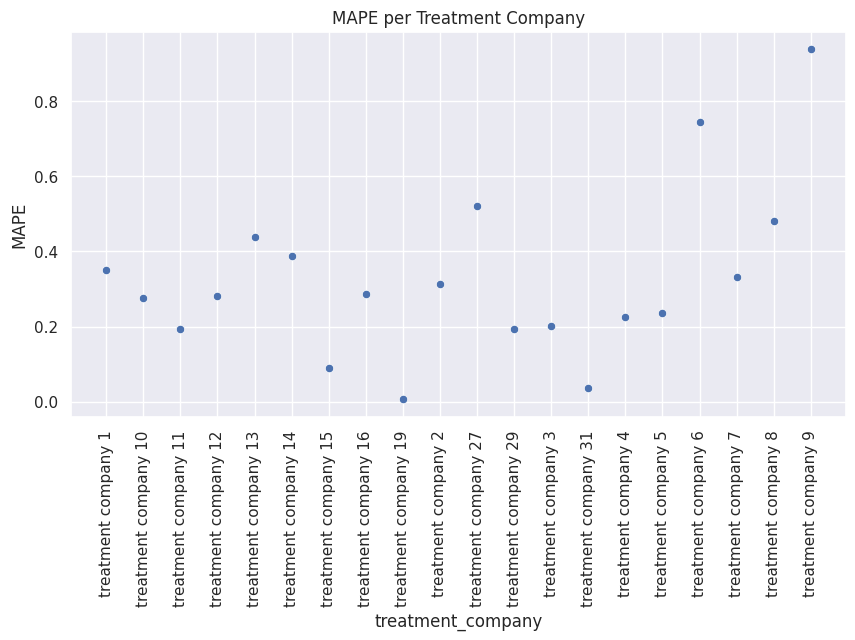

In [148]:
# sum of predictions
df81 = df8[['treatment_company', 'predictions']].groupby('treatment_company').sum().reset_index()

# MAE and MAPE
df8_aux1 = df8[['treatment_company', 'production', 'predictions']].groupby('treatment_company').apply(lambda x: mt.mean_absolute_error(x['production'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df8_aux2 = df8[['treatment_company', 'production', 'predictions']].groupby('treatment_company').apply(lambda x: mean_absolute_percentage_error(x['production'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge
df8_aux3 = pd.merge(df8_aux1, df8_aux2, how='inner', on='treatment_company')
df82 = pd.merge(df81, df8_aux3, how='inner', on='treatment_company')

# scenarios
df82['worst_scenario'] = df82['predictions'] - df82['MAE']
df82['best_scenario'] = df82['predictions'] + df82['MAE']

# order columns
df82 = df82[['treatment_company', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

plt.figure(figsize=(10, 5))
sns.scatterplot(x='treatment_company', y='MAPE', data=df82);
plt.xticks(rotation=90);
plt.title('MAPE per Treatment Company');

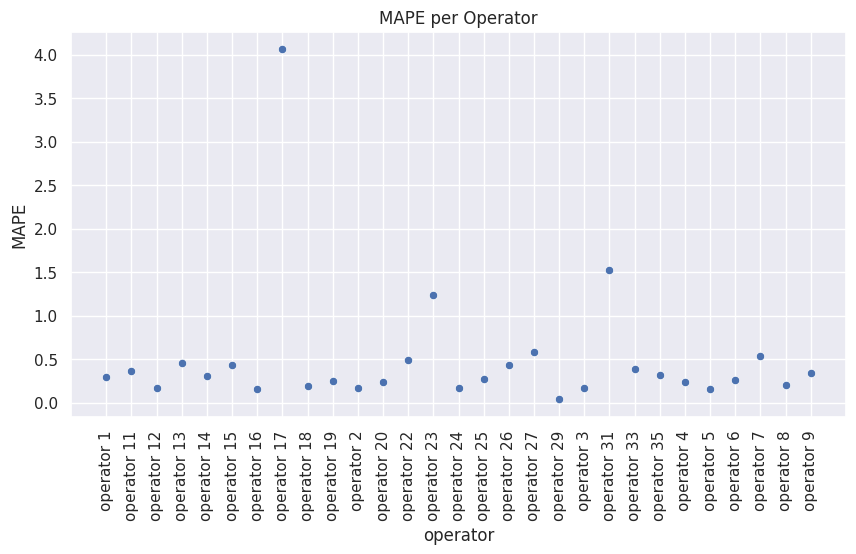

In [149]:
# sum of predictions
df81 = df8[['operator', 'predictions']].groupby('operator').sum().reset_index()

# MAE and MAPE
df8_aux1 = df8[['operator', 'production', 'predictions']].groupby('operator').apply(lambda x: mt.mean_absolute_error(x['production'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df8_aux2 = df8[['operator', 'production', 'predictions']].groupby('operator').apply(lambda x: mean_absolute_percentage_error(x['production'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge
df8_aux3 = pd.merge(df8_aux1, df8_aux2, how='inner', on='operator')
df82 = pd.merge(df81, df8_aux3, how='inner', on='operator')

# scenarios
df82['worst_scenario'] = df82['predictions'] - df82['MAE']
df82['best_scenario'] = df82['predictions'] + df82['MAE']

# order columns
df82 = df82[['operator', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

plt.figure(figsize=(10, 5))
sns.scatterplot(x='operator', y='MAPE', data=df82);
plt.xticks(rotation=90);
plt.title('MAPE per Operator');

## 8.2. Machine Learning Performance

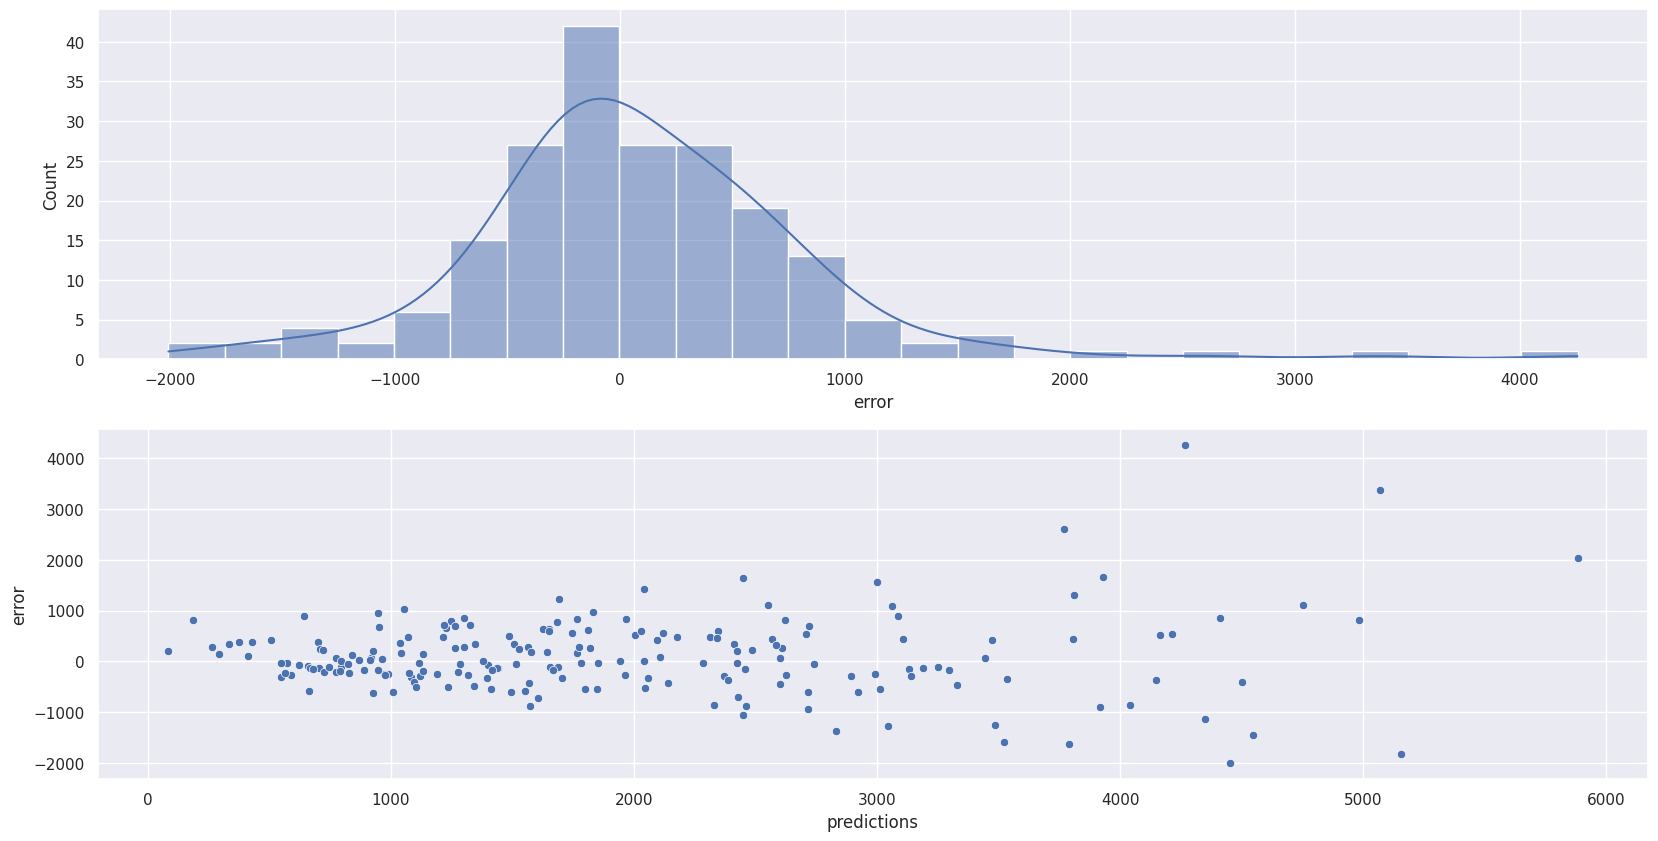

In [150]:
df8['error'] = (df8['production'] - df8['predictions'])
df8['error_rate'] = df8['predictions'] / df8['production']

plt.subplot(2, 1, 1)
sns.histplot(df8['error'], kde=True);

plt.subplot(2, 1, 2)
sns.scatterplot(x=df8['predictions'], y=df8['error']);

# 9. Model Deployment

In [ ]:
import pickle

import numpy as np
import pandas as pd

import catboost as ctb

from sklearn import impute as im
from sklearn import preprocessing as pp

class production_prediction():

    def __init__(self):

        self.home_path = ''
        self.fe_operator = pickle.load(open(self.home_path + '../feature_transformation/fe_operator.pkl', 'rb'))
        self.rs_azimuth = pickle.load(open(self.home_path + '../feature_transformation/rs_azimuth.pkl', 'rb'))

        self.mm_md_ft = pickle.load(open(self.home_path + '../feature_transformation/mm_md_ft.pkl', 'rb'))
        self.ss_tvd_ft = pickle.load(open(self.home_path + '../feature_transformation/ss_tvd_ft.pkl', 'rb'))
        self.mm_footage_lateral_length = pickle.load(open(self.home_path + '../feature_transformation/mm_footage_lateral_length.pkl', 'rb'))
        self.mm_p_velocity = pickle.load(open(self.home_path + '../feature_transformation/mm_p-velocity.pkl', 'rb'))
        self.rs_s_velocity = pickle.load(open(self.home_path + '../feature_transformation/rs_s-velocity.pkl', 'rb'))
        self.mm_youngs_modulus = pickle.load(open(self.home_path + '../feature_transformation/mm_youngs_modulus.pkl', 'rb'))
        self.rs_isip = pickle.load(open(self.home_path + '../feature_transformation/rs_isip.pkl', 'rb'))
        self.rs_pump_rate = pickle.load(open(self.home_path + '../feature_transformation/rs_pump_rate.pkl', 'rb'))
        self.mm_total_number_of_stages = pickle.load(open(self.home_path + '../feature_transformation/mm_total_number_of_stages.pkl', 'rb'))
        self.mm_proppant_volume = pickle.load(open(self.home_path + '../feature_transformation/mm_proppant_volume.pkl', 'rb'))
        self.rs_proppant_fluid_ratio = pickle.load(open(self.home_path + '../feature_transformation/rs_proppant_fluid_ratio.pkl', 'rb'))
        self.mm_year_on_production = pickle.load(open(self.home_path + '../feature_transformation/mm_year_on_production.pkl', 'rb'))
        self.mm_production = pickle.load(open(self.home_path + '../feature_transformation/mm_production.pkl', 'rb'))

        self.ctbm_tuned = pickle.load(open(self.home_path + '../model/ctbm_tuned.pkl', 'rb'))

    def data_cleaning(self, df1):

        old_column_names = ['treatment company', 'azimuth', 'md (ft)', 'tvd (ft)', 'date on production', 'operator', 'footage lateral length', 'well spacing', 
                            'porpoise deviation', 'porpoise count', 'shale footage', 'acoustic impedance', 'log permeability', 'porosity', 'poisson ratio', 
                            'water saturation', 'toc', 'vcl', 'p-velocity', 's-velocity', 'youngs modulus', 'isip', 'breakdown pressure', 'pump rate', 
                            'total number of stages', 'proppant volume', 'proppant fluid ratio', 'production']

        new_column_names = [old_name.replace(' ', '_') for old_name in old_column_names]

        df1.columns = new_column_names

        df1['date_on_production'] = pd.to_datetime(df1['date_on_production'])

        return df1
    
    def feature_engineering(self, df2):

        df2['month_on_production'] = df2['date_on_production'].dt.month
        df2['year_on_production'] = df2['date_on_production'].dt.year

        return df2

    def data_preparation(self, df4):

        df4['operator'] = df4['operator'].map(self.fe_operator)
        df4['azimuth'] = self.rs_azimuth.fit_transform(df4[['azimuth']].values)
        df4['md_(ft)'] = self.mm_md_ft.fit_transform(df4[['md_(ft)']].values)
        df4['tvd_(ft)'] = self.ss_tvd_ft.fit_transform(df4[['tvd_(ft)']].values)
        df4['footage_lateral_length'] = self.mm_footage_lateral_length.fit_transform(df4[['footage_lateral_length']].values)
        df4['p-velocity'] = self.mm_p_velocity.fit_transform(df4[['p-velocity']].values)
        df4['s-velocity'] = self.rs_s_velocity.fit_transform(df4[['s-velocity']].values)
        df4['youngs_modulus'] = self.mm_youngs_modulus.fit_transform(df4[['youngs_modulus']].values)
        df4['isip'] = self.rs_isip.fit_transform(df4[['isip']].values)
        df4['pump_rate'] = self.rs_pump_rate.fit_transform(df4[['pump_rate']].values)
        df4['total_number_of_stages'] = self.mm_total_number_of_stages.fit_transform(df4[['total_number_of_stages']].values)
        df4['proppant_volume'] = self.mm_proppant_volume.fit_transform(df4[['proppant_volume']].values)
        df4['proppant_fluid_ratio'] = self.rs_proppant_fluid_ratio.fit_transform(df4[['proppant_fluid_ratio']].values)
        df4['year_on_production'] = self.mm_year_on_production.fit_transform(df4[['year_on_production']].values)

        columns_selected = ['md_(ft)', 'tvd_(ft)', 'operator', 'p-velocity', 's-velocity', 'youngs_modulus', 'isip', 'pump_rate',  'total_number_of_stages', 
                            'proppant_volume', 'proppant_fluid_ratio', 'footage_lateral_length',  'year_on_production', 'azimuth']

        return df4[columns_selected]

    def get_prediction(self, df):
        
        df['production'] = self.mm_production.inverse_transform([self.ctbm_tuned.predict(df)])

        return df